1. Understand the problem and read in the data
2. Pre-process data, train-test split
3. Build and compile a deep learning model

# Understand the problem and read in the data

This Kaggle challenge is about predicting the onset of diabetes in 5 years or less. 
Target variable is Outcome. 1 = yes, the person became diabetic in 5 years, and 0 = No, 
the person did not. This is a binary classification problem. Please check out the Kaggle
link here to see feature 
details - https://www.kaggle.com/uciml/pima-indians-diabetes-database/data

In [1]:
'''Import necessary packages'''
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import numpy as np

%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Check the path to the directory where you are currently in
%pwd
mypath = %pwd

In [3]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = '%s' %mypath

# II. Reading data into the notebook

In [4]:
my_df = pd.read_csv(f'{my_path}/diabetes.csv')
print(my_df.shape)
my_df.head(2)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(my_df)

# III. Train - Valid- Test Split

In [6]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 768. This is about 118 rows of data. 
#So, 768 - 118 = 650 rows of data will remain for the
#train and valid sets which we will separate later. 118 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,650)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(650, 9) (118, 9)


# IV. Data Pre-processing

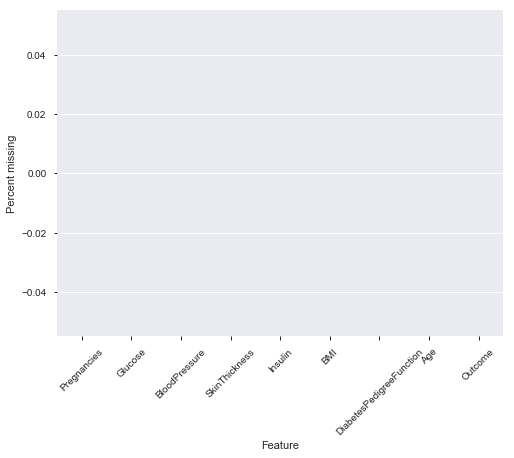

In [7]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

%matplotlib inline
null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [8]:
#Check types of each column with the dataframe info () method
mydf_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 9 columns):
Pregnancies                 650 non-null int64
Glucose                     650 non-null int64
BloodPressure               650 non-null int64
SkinThickness               650 non-null int64
Insulin                     650 non-null int64
BMI                         650 non-null float64
DiabetesPedigreeFunction    650 non-null float64
Age                         650 non-null int64
Outcome                     650 non-null int64
dtypes: float64(2), int64(7)
memory usage: 45.8 KB


'''Since all the data is in int or float type we dont need to do any conversion of data'''

'''
We are predicting outcome of patient status, such it has diabetes or not
Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict the
Outcome(0 = No, 1 = Yes)'''

Y = mydf_train_valid["Outcome"]
X = mydf_train_valid.drop(["Outcome"],axis = 1)

print(X.shape,Y.shape)
X.head(15)

In [9]:
#Separate out X and Y

X = mydf_train_valid.iloc[:, :8]
Y = mydf_train_valid.iloc[:, 8:9]

print(X.shape,Y.shape)
X.head(15)

(650, 8) (650, 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26
7,10,115,0,0,0,35.3,0.134,29
8,2,197,70,45,543,30.5,0.158,53
9,8,125,96,0,0,0.0,0.232,54


In [10]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Insulin and BMI columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

X_con = X[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age']]
X_cat = X.drop(X_con,axis = 1)
print(X_cat.shape,X_con.shape)

(650, 0) (650, 8)


In [11]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age']
print(X_con_sc.shape)
X_con_sc.head(2)

(650, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.656098,0.859476,0.173071,0.918925,-0.68566,0.226439,0.437697,1.454721
1,-0.833992,-1.088797,-0.133180,0.542948,-0.68566,-0.662745,-0.375885,-0.175422


In [12]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(650, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.656098,0.859476,0.173071,0.918925,-0.68566,0.226439,0.437697,1.454721
1,-0.833992,-1.088797,-0.133180,0.542948,-0.68566,-0.662745,-0.375885,-0.175422


In [13]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X_full,550)
Y_train,Y_valid = mydf_splitter(Y,550)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(550, 8) (100, 8) (550, 1) (100, 1)


# Build and compile a deep learning model

In [14]:
# Build the deep neural network
model = Sequential()
model.add(Dense(10, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(6, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

W0807 15:22:59.348270 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0807 15:22:59.397094 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 15:22:59.399092 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

C:\ProgramData\Anaco

In [15]:
# Compile the DNN

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0807 15:22:59.495645 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 15:22:59.549342 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0807 15:22:59.554506 16140 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
# Fit the DNN with your train data

model_output= model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=100, batch_size=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until
W0807 15:22:59.755813 16140 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 550 samples, validate on 100 samples
Epoch 1/100
550/550 [==============================] - 0s 613us/step - loss: 0.6845 - acc: 0.6455 - val_loss: 0.6542 - val_acc: 0.7200
Epoch 2/100
550/550 [==============================] - 0s 170us/step - loss: 0.6103 - acc: 0.6455 - val_loss: 0.4810 - val_acc: 0.7200
Epoch 3/100
550/550 [==============================] - 0s 170us/step - loss: 0.5366 - acc: 0.6691 - val_loss: 0.4179 - val_acc: 0.8200
Epoch 4/100
550/550 [==============================] - 0s 199us/step - loss: 0.5180 - acc: 0.7709 - val_loss: 0.3939 - val_acc: 0.8200
Epoch 5/100
550/550 [==============================] - 0s 170us/step - loss: 0.5066 - acc: 0.7764 - val_loss: 0.3802 - val_acc: 0.8300
Epoch 6/100
550/550 [==============================] - 0s 170us/step - loss: 0.4967 - acc: 0.7673 - val_loss: 0.3729 - val_acc: 0.8300
Epoch 7/100
550/550 [==============================] - 0s 170us/step - loss: 0.4903 - acc: 0.7655 - val_loss: 0.3629 - val_acc: 0.8300
Epoch 8/1

Epoch 61/100
550/550 [==============================] - 0s 199us/step - loss: 0.4490 - acc: 0.7800 - val_loss: 0.3429 - val_acc: 0.8400
Epoch 62/100
550/550 [==============================] - 0s 170us/step - loss: 0.4479 - acc: 0.7855 - val_loss: 0.3426 - val_acc: 0.8300
Epoch 63/100
550/550 [==============================] - 0s 199us/step - loss: 0.4474 - acc: 0.7800 - val_loss: 0.3434 - val_acc: 0.8100
Epoch 64/100
550/550 [==============================] - 0s 201us/step - loss: 0.4469 - acc: 0.7855 - val_loss: 0.3434 - val_acc: 0.8200
Epoch 65/100
550/550 [==============================] - 0s 197us/step - loss: 0.4475 - acc: 0.7855 - val_loss: 0.3429 - val_acc: 0.8300
Epoch 66/100
550/550 [==============================] - 0s 176us/step - loss: 0.4474 - acc: 0.7818 - val_loss: 0.3418 - val_acc: 0.8200
Epoch 67/100
550/550 [==============================] - 0s 231us/step - loss: 0.4470 - acc: 0.7818 - val_loss: 0.3439 - val_acc: 0.8300
Epoch 68/100
550/550 [==========================

In [17]:
print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))

Training Accuracy :  0.7773454652604732
Validation Accuracy :  0.8309000090062617


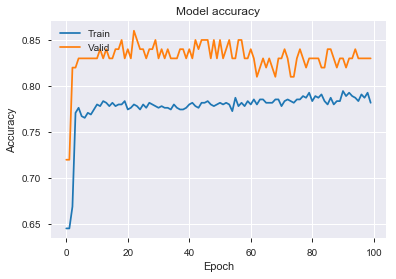

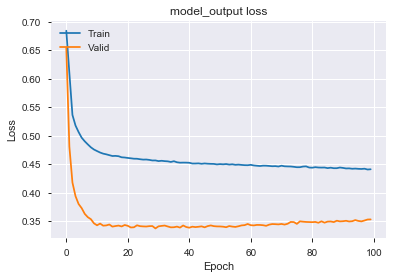

In [18]:
# Plot training & validation accuracy values
plt.plot(model_output.history['acc'])
plt.plot(model_output.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

model_output = model.fit(x_train,y_train,epochs=500,batch_size=20,verbose=1,validation_data=(x_test,y_test),)

In [19]:
# Evaluate the model
scores = model.evaluate(X_valid, Y_valid)
print ("Accuracy: %.2f%%" %(scores[1]*100))

100/100 [==============================] - 0s 0us/step
Accuracy: 83.00%


# V. Hyperparameter tuning

In [20]:
# Hyperparameter tuning 


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense


def build_classifier (optimizer): 
    model = Sequential()
    model.add(Dense(10, input_dim=8, init='uniform', activation='relu'))
    model.add(Dense(6, init='uniform', activation='relu'))
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn =build_classifier)

parameters = { 'batch_size':[25,32],
               'epochs' :[1,2],
              'optimizer' :['adam','rmsprop']}


grid_search = GridSearchCV(estimator = model,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv= 10)

grid_result = grid_search.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=100, batch_size=5)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
print(means)
stds = grid_result.cv_results_['std_test_score']
print(stds)
params = grid_result.cv_results_['params']
print(params)

print('Training Accuracy :',grid_result.best_estimator_.model.history.history["acc"])

print('Validation Accuracy :',grid_result.best_estimator_.model.history.history["val_acc"])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 0s 668us/step - loss: 0.6867 - acc: 0.6525 - val_loss: 0.6691 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 189us/step - loss: 0.6432 - acc: 0.6626 - val_loss: 0.5617 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 174us/step - loss: 0.5515 - acc: 0.7636 - val_loss: 0.4438 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 194us/step - loss: 0.4953 - acc: 0.7717 - val_loss: 0.3852 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 175us/step - loss: 0.4736 - acc: 0.7677 - val_loss: 0.3611 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4663 - acc: 0.7798 - val_loss: 0.3503 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 203us/step - loss: 0.4619 - acc: 0.7717 - val_loss: 0.3466 - val_acc: 0.8400
Epoch 8/1

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4198 - acc: 0.7960 - val_loss: 0.3342 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 189us/step - loss: 0.4193 - acc: 0.7960 - val_loss: 0.3340 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4184 - acc: 0.8020 - val_loss: 0.3340 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4185 - acc: 0.7980 - val_loss: 0.3326 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4176 - acc: 0.8020 - val_loss: 0.3348 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 189us/step - loss: 0.4170 - acc: 0.8040 - val_loss: 0.3328 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 186us/step - loss: 0.4168 - acc: 0.8061 - val_loss: 0.3332 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 0s 789us/step - loss: 0.6854 - acc: 0.6303 - val_loss: 0.6594 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 192us/step - loss: 0.6261 - acc: 0.6323 - val_loss: 0.5113 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 165us/step - loss: 0.5523 - acc: 0.7030 - val_loss: 0.4302 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5261 - acc: 0.7576 - val_loss: 0.3984 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 189us/step - loss: 0.5086 - acc: 0.7616 - val_loss: 0.3821 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4988 - acc: 0.7677 - val_loss: 0.3734 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4934 - acc: 0.7717 - val_loss: 0.3638 - val_acc: 0.8400
Epoch 8/1

Epoch 61/100
495/495 [==============================] - 0s 189us/step - loss: 0.4540 - acc: 0.7737 - val_loss: 0.3455 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 189us/step - loss: 0.4536 - acc: 0.7778 - val_loss: 0.3465 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4533 - acc: 0.7798 - val_loss: 0.3470 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 189us/step - loss: 0.4527 - acc: 0.7818 - val_loss: 0.3449 - val_acc: 0.8700
Epoch 65/100
495/495 [==============================] - 0s 203us/step - loss: 0.4532 - acc: 0.7778 - val_loss: 0.3459 - val_acc: 0.8700
Epoch 66/100
495/495 [==============================] - 0s 163us/step - loss: 0.4535 - acc: 0.7838 - val_loss: 0.3470 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 189us/step - loss: 0.4528 - acc: 0.7818 - val_loss: 0.3443 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 0s 859us/step - loss: 0.6881 - acc: 0.6343 - val_loss: 0.6700 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 189us/step - loss: 0.6350 - acc: 0.6444 - val_loss: 0.5268 - val_acc: 0.7100
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5476 - acc: 0.7192 - val_loss: 0.4263 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5150 - acc: 0.7596 - val_loss: 0.3944 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 189us/step - loss: 0.4995 - acc: 0.7596 - val_loss: 0.3791 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4925 - acc: 0.7657 - val_loss: 0.3721 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4887 - acc: 0.7697 - val_loss: 0.3700 - val_acc: 0.8400
Epoch 8/1

Epoch 61/100
495/495 [==============================] - 0s 207us/step - loss: 0.4582 - acc: 0.7758 - val_loss: 0.3594 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 194us/step - loss: 0.4562 - acc: 0.7859 - val_loss: 0.3587 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4560 - acc: 0.7859 - val_loss: 0.3577 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 189us/step - loss: 0.4583 - acc: 0.7838 - val_loss: 0.3596 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4565 - acc: 0.7778 - val_loss: 0.3585 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 189us/step - loss: 0.4566 - acc: 0.7919 - val_loss: 0.3597 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 189us/step - loss: 0.4561 - acc: 0.7798 - val_loss: 0.3610 - val_acc: 0.8100
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 0s 954us/step - loss: 0.6848 - acc: 0.6586 - val_loss: 0.6580 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 189us/step - loss: 0.6191 - acc: 0.6586 - val_loss: 0.5044 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5400 - acc: 0.6586 - val_loss: 0.4351 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 189us/step - loss: 0.5231 - acc: 0.6586 - val_loss: 0.4117 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 212us/step - loss: 0.5180 - acc: 0.6586 - val_loss: 0.4057 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 167us/step - loss: 0.5134 - acc: 0.6586 - val_loss: 0.3948 - val_acc: 0.7200
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.5099 - acc: 0.7556 - val_loss: 0.3937 - val_acc: 0.8300
Epoch 8/1

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4515 - acc: 0.7939 - val_loss: 0.3326 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 189us/step - loss: 0.4536 - acc: 0.7960 - val_loss: 0.3355 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4526 - acc: 0.7919 - val_loss: 0.3335 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 189us/step - loss: 0.4511 - acc: 0.8061 - val_loss: 0.3338 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4502 - acc: 0.8000 - val_loss: 0.3327 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 189us/step - loss: 0.4491 - acc: 0.7919 - val_loss: 0.3323 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 209us/step - loss: 0.4497 - acc: 0.7919 - val_loss: 0.3299 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 1ms/step - loss: 0.6876 - acc: 0.6424 - val_loss: 0.6693 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6414 - acc: 0.6768 - val_loss: 0.5498 - val_acc: 0.8000
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5472 - acc: 0.7515 - val_loss: 0.4265 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5017 - acc: 0.7616 - val_loss: 0.3821 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 189us/step - loss: 0.4865 - acc: 0.7657 - val_loss: 0.3695 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4819 - acc: 0.7636 - val_loss: 0.3621 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4784 - acc: 0.7576 - val_loss: 0.3603 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4463 - acc: 0.7939 - val_loss: 0.3543 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4467 - acc: 0.7879 - val_loss: 0.3537 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4465 - acc: 0.7960 - val_loss: 0.3542 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4455 - acc: 0.7980 - val_loss: 0.3539 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4454 - acc: 0.7960 - val_loss: 0.3535 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 233us/step - loss: 0.4445 - acc: 0.7879 - val_loss: 0.3532 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 211us/step - loss: 0.4444 - acc: 0.7960 - val_loss: 0.3541 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 1ms/step - loss: 0.6851 - acc: 0.6505 - val_loss: 0.6591 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 194us/step - loss: 0.6185 - acc: 0.6566 - val_loss: 0.5084 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - ETA: 0s - loss: 0.5211 - acc: 0.690 - 0s 189us/step - loss: 0.5326 - acc: 0.6929 - val_loss: 0.4248 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 189us/step - loss: 0.5047 - acc: 0.7818 - val_loss: 0.3945 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 189us/step - loss: 0.4895 - acc: 0.7758 - val_loss: 0.3803 - val_acc: 0.8500
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4791 - acc: 0.7758 - val_loss: 0.3694 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4720 - acc: 0.7737 - val_loss

Epoch 61/100
495/495 [==============================] - 0s 189us/step - loss: 0.4231 - acc: 0.7980 - val_loss: 0.3524 - val_acc: 0.8100
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4234 - acc: 0.7980 - val_loss: 0.3508 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4222 - acc: 0.7960 - val_loss: 0.3521 - val_acc: 0.8100
Epoch 64/100
495/495 [==============================] - 0s 189us/step - loss: 0.4225 - acc: 0.8000 - val_loss: 0.3536 - val_acc: 0.8100
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4229 - acc: 0.7960 - val_loss: 0.3534 - val_acc: 0.8100
Epoch 66/100
495/495 [==============================] - 0s 215us/step - loss: 0.4224 - acc: 0.7980 - val_loss: 0.3528 - val_acc: 0.8100
Epoch 67/100
495/495 [==============================] - 0s 195us/step - loss: 0.4215 - acc: 0.7960 - val_loss: 0.3537 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 1ms/step - loss: 0.6884 - acc: 0.6283 - val_loss: 0.6719 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6484 - acc: 0.6384 - val_loss: 0.5588 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5668 - acc: 0.6525 - val_loss: 0.4498 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5286 - acc: 0.7535 - val_loss: 0.4048 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 189us/step - loss: 0.5125 - acc: 0.7677 - val_loss: 0.3850 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 222us/step - loss: 0.5027 - acc: 0.7636 - val_loss: 0.3743 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4965 - acc: 0.7758 - val_loss: 0.3646 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 189us/step - loss: 0.4586 - acc: 0.7838 - val_loss: 0.3399 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4589 - acc: 0.7798 - val_loss: 0.3396 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 189us/step - loss: 0.4591 - acc: 0.7838 - val_loss: 0.3413 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4580 - acc: 0.7919 - val_loss: 0.3396 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 215us/step - loss: 0.4578 - acc: 0.7798 - val_loss: 0.3386 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 189us/step - loss: 0.4569 - acc: 0.7798 - val_loss: 0.3399 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 221us/step - loss: 0.4576 - acc: 0.7859 - val_loss: 0.3397 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 1ms/step - loss: 0.6863 - acc: 0.6404 - val_loss: 0.6620 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6269 - acc: 0.6505 - val_loss: 0.5220 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5459 - acc: 0.6869 - val_loss: 0.4333 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 228us/step - loss: 0.5167 - acc: 0.7697 - val_loss: 0.3958 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 196us/step - loss: 0.5017 - acc: 0.7758 - val_loss: 0.3801 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4926 - acc: 0.7798 - val_loss: 0.3740 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4868 - acc: 0.7859 - val_loss: 0.3648 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 220us/step - loss: 0.4401 - acc: 0.7980 - val_loss: 0.3400 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4386 - acc: 0.8061 - val_loss: 0.3408 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4379 - acc: 0.8061 - val_loss: 0.3390 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4373 - acc: 0.8040 - val_loss: 0.3390 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4384 - acc: 0.8020 - val_loss: 0.3403 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4380 - acc: 0.8040 - val_loss: 0.3392 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 200us/step - loss: 0.4372 - acc: 0.8040 - val_loss: 0.3380 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 1ms/step - loss: 0.6893 - acc: 0.6182 - val_loss: 0.6770 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6546 - acc: 0.6343 - val_loss: 0.5719 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5678 - acc: 0.6727 - val_loss: 0.4494 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 189us/step - loss: 0.5277 - acc: 0.7616 - val_loss: 0.4088 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5095 - acc: 0.7535 - val_loss: 0.3836 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4978 - acc: 0.7677 - val_loss: 0.3736 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4905 - acc: 0.7636 - val_loss: 0.3695 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4521 - acc: 0.7758 - val_loss: 0.3443 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 189us/step - loss: 0.4519 - acc: 0.7758 - val_loss: 0.3437 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4525 - acc: 0.7758 - val_loss: 0.3440 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 211us/step - loss: 0.4520 - acc: 0.7737 - val_loss: 0.3441 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4520 - acc: 0.7737 - val_loss: 0.3436 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 210us/step - loss: 0.4513 - acc: 0.7778 - val_loss: 0.3440 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 194us/step - loss: 0.4510 - acc: 0.7758 - val_loss: 0.3428 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6882 - acc: 0.6263 - val_loss: 0.6726 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6575 - acc: 0.6505 - val_loss: 0.5939 - val_acc: 0.8100
Epoch 3/100
495/495 [==============================] - 0s 189us/step - loss: 0.5873 - acc: 0.7556 - val_loss: 0.4866 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 239us/step - loss: 0.5285 - acc: 0.7556 - val_loss: 0.4197 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 196us/step - loss: 0.5028 - acc: 0.7697 - val_loss: 0.3876 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 189us/step - loss: 0.4934 - acc: 0.7677 - val_loss: 0.3729 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 189us/step - loss: 0.4894 - acc: 0.7576 - val_loss: 0.3657 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 222us/step - loss: 0.4508 - acc: 0.7939 - val_loss: 0.3535 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4503 - acc: 0.7879 - val_loss: 0.3536 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4498 - acc: 0.7838 - val_loss: 0.3535 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 222us/step - loss: 0.4496 - acc: 0.7818 - val_loss: 0.3537 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 210us/step - loss: 0.4491 - acc: 0.7798 - val_loss: 0.3541 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4485 - acc: 0.7859 - val_loss: 0.3533 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 233us/step - loss: 0.4487 - acc: 0.7879 - val_loss: 0.3531 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6844 - acc: 0.6545 - val_loss: 0.6544 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 200us/step - loss: 0.6120 - acc: 0.6586 - val_loss: 0.4939 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 229us/step - loss: 0.5338 - acc: 0.6586 - val_loss: 0.4228 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5157 - acc: 0.6586 - val_loss: 0.4046 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5093 - acc: 0.6586 - val_loss: 0.4002 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5054 - acc: 0.6667 - val_loss: 0.3932 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.5028 - acc: 0.7737 - val_loss: 0.3878 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4287 - acc: 0.8020 - val_loss: 0.3311 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4284 - acc: 0.8020 - val_loss: 0.3308 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4263 - acc: 0.8061 - val_loss: 0.3330 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4267 - acc: 0.8020 - val_loss: 0.3341 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 239us/step - loss: 0.4256 - acc: 0.8061 - val_loss: 0.3339 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 205us/step - loss: 0.4254 - acc: 0.8040 - val_loss: 0.3360 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 221us/step - loss: 0.4240 - acc: 0.8020 - val_loss: 0.3353 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6867 - acc: 0.6303 - val_loss: 0.6605 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6281 - acc: 0.6323 - val_loss: 0.5153 - val_acc: 0.7100
Epoch 3/100
495/495 [==============================] - 0s 231us/step - loss: 0.5508 - acc: 0.7051 - val_loss: 0.4279 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 222us/step - loss: 0.5241 - acc: 0.7596 - val_loss: 0.3979 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 230us/step - loss: 0.5094 - acc: 0.7657 - val_loss: 0.3815 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5004 - acc: 0.7657 - val_loss: 0.3701 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.4962 - acc: 0.7677 - val_loss: 0.3678 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 236us/step - loss: 0.4617 - acc: 0.7697 - val_loss: 0.3496 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 227us/step - loss: 0.4628 - acc: 0.7596 - val_loss: 0.3513 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4616 - acc: 0.7758 - val_loss: 0.3545 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4615 - acc: 0.7677 - val_loss: 0.3506 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4602 - acc: 0.7677 - val_loss: 0.3513 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4609 - acc: 0.7697 - val_loss: 0.3514 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 221us/step - loss: 0.4593 - acc: 0.7677 - val_loss: 0.3525 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6872 - acc: 0.6465 - val_loss: 0.6659 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6389 - acc: 0.6444 - val_loss: 0.5432 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 209us/step - loss: 0.5592 - acc: 0.6525 - val_loss: 0.4480 - val_acc: 0.8000
Epoch 4/100
495/495 [==============================] - 0s 196us/step - loss: 0.5294 - acc: 0.7394 - val_loss: 0.4151 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5156 - acc: 0.7515 - val_loss: 0.4003 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5058 - acc: 0.7657 - val_loss: 0.3874 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.4973 - acc: 0.7737 - val_loss: 0.3772 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4551 - acc: 0.7899 - val_loss: 0.3641 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4538 - acc: 0.7919 - val_loss: 0.3627 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4544 - acc: 0.7879 - val_loss: 0.3633 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4532 - acc: 0.7859 - val_loss: 0.3630 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 228us/step - loss: 0.4534 - acc: 0.7919 - val_loss: 0.3642 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4523 - acc: 0.7879 - val_loss: 0.3618 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 238us/step - loss: 0.4531 - acc: 0.7919 - val_loss: 0.3608 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6875 - acc: 0.6545 - val_loss: 0.6752 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 195us/step - loss: 0.6601 - acc: 0.6586 - val_loss: 0.6014 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5874 - acc: 0.6586 - val_loss: 0.4864 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5365 - acc: 0.7111 - val_loss: 0.4302 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5148 - acc: 0.7697 - val_loss: 0.3998 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 215us/step - loss: 0.5017 - acc: 0.7838 - val_loss: 0.3842 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.4919 - acc: 0.7737 - val_loss: 0.3720 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 253us/step - loss: 0.4478 - acc: 0.7939 - val_loss: 0.3319 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 189us/step - loss: 0.4476 - acc: 0.7939 - val_loss: 0.3332 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4478 - acc: 0.7939 - val_loss: 0.3319 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 204us/step - loss: 0.4467 - acc: 0.7939 - val_loss: 0.3314 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4474 - acc: 0.7919 - val_loss: 0.3311 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4466 - acc: 0.7919 - val_loss: 0.3309 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 189us/step - loss: 0.4468 - acc: 0.7939 - val_loss: 0.3324 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6865 - acc: 0.6121 - val_loss: 0.6652 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 252us/step - loss: 0.6356 - acc: 0.6505 - val_loss: 0.5433 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5546 - acc: 0.7354 - val_loss: 0.4444 - val_acc: 0.8000
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5104 - acc: 0.7677 - val_loss: 0.4009 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4928 - acc: 0.7616 - val_loss: 0.3816 - val_acc: 0.8600
Epoch 6/100
495/495 [==============================] - 0s 233us/step - loss: 0.4851 - acc: 0.7636 - val_loss: 0.3707 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.4820 - acc: 0.7677 - val_loss: 0.3656 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4514 - acc: 0.7859 - val_loss: 0.3492 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 240us/step - loss: 0.4516 - acc: 0.7859 - val_loss: 0.3520 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4507 - acc: 0.7899 - val_loss: 0.3506 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4505 - acc: 0.7798 - val_loss: 0.3498 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4498 - acc: 0.7960 - val_loss: 0.3495 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 243us/step - loss: 0.4505 - acc: 0.7838 - val_loss: 0.3495 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 197us/step - loss: 0.4495 - acc: 0.7919 - val_loss: 0.3515 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6867 - acc: 0.6545 - val_loss: 0.6679 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 201us/step - loss: 0.6229 - acc: 0.6566 - val_loss: 0.5119 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5318 - acc: 0.6727 - val_loss: 0.4254 - val_acc: 0.7600
Epoch 4/100
495/495 [==============================] - 0s 204us/step - loss: 0.5058 - acc: 0.7758 - val_loss: 0.3997 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4906 - acc: 0.7919 - val_loss: 0.3803 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 203us/step - loss: 0.4782 - acc: 0.7859 - val_loss: 0.3659 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.4689 - acc: 0.7818 - val_loss: 0.3556 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4216 - acc: 0.8000 - val_loss: 0.3476 - val_acc: 0.8100
Epoch 62/100
495/495 [==============================] - 0s 206us/step - loss: 0.4217 - acc: 0.7960 - val_loss: 0.3494 - val_acc: 0.8100
Epoch 63/100
495/495 [==============================] - 0s 252us/step - loss: 0.4220 - acc: 0.8000 - val_loss: 0.3470 - val_acc: 0.8100
Epoch 64/100
495/495 [==============================] - 0s 227us/step - loss: 0.4216 - acc: 0.7980 - val_loss: 0.3499 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 227us/step - loss: 0.4209 - acc: 0.8020 - val_loss: 0.3491 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 205us/step - loss: 0.4224 - acc: 0.8020 - val_loss: 0.3503 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 221us/step - loss: 0.4206 - acc: 0.8000 - val_loss: 0.3486 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6867 - acc: 0.6343 - val_loss: 0.6637 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6320 - acc: 0.6364 - val_loss: 0.5266 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 237us/step - loss: 0.5503 - acc: 0.6990 - val_loss: 0.4264 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 199us/step - loss: 0.5196 - acc: 0.7535 - val_loss: 0.3918 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5063 - acc: 0.7596 - val_loss: 0.3737 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4982 - acc: 0.7737 - val_loss: 0.3627 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.4919 - acc: 0.7657 - val_loss: 0.3628 - val_acc: 0.8600
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4502 - acc: 0.7737 - val_loss: 0.3380 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4497 - acc: 0.7818 - val_loss: 0.3379 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 234us/step - loss: 0.4504 - acc: 0.7778 - val_loss: 0.3363 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4494 - acc: 0.7758 - val_loss: 0.3383 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 237us/step - loss: 0.4483 - acc: 0.7778 - val_loss: 0.3363 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 222us/step - loss: 0.4486 - acc: 0.7798 - val_loss: 0.3365 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 229us/step - loss: 0.4468 - acc: 0.7758 - val_loss: 0.3350 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6844 - acc: 0.6505 - val_loss: 0.6531 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6127 - acc: 0.6505 - val_loss: 0.4938 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5409 - acc: 0.6505 - val_loss: 0.4282 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 222us/step - loss: 0.5265 - acc: 0.6505 - val_loss: 0.4105 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 226us/step - loss: 0.5212 - acc: 0.6505 - val_loss: 0.4051 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5173 - acc: 0.6808 - val_loss: 0.4007 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 221us/step - loss: 0.5139 - acc: 0.7636 - val_loss: 0.3959 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4411 - acc: 0.8020 - val_loss: 0.3448 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4395 - acc: 0.8020 - val_loss: 0.3458 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 253us/step - loss: 0.4398 - acc: 0.8000 - val_loss: 0.3466 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 241us/step - loss: 0.4392 - acc: 0.7899 - val_loss: 0.3457 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 227us/step - loss: 0.4379 - acc: 0.8000 - val_loss: 0.3446 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4383 - acc: 0.8000 - val_loss: 0.3482 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4370 - acc: 0.8000 - val_loss: 0.3486 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6853 - acc: 0.6263 - val_loss: 0.6553 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 207us/step - loss: 0.6153 - acc: 0.6343 - val_loss: 0.4903 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5471 - acc: 0.6343 - val_loss: 0.4292 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5325 - acc: 0.6343 - val_loss: 0.4148 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.5286 - acc: 0.6343 - val_loss: 0.4055 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5239 - acc: 0.7434 - val_loss: 0.4028 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.5216 - acc: 0.7737 - val_loss: 0.4012 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 253us/step - loss: 0.4559 - acc: 0.7899 - val_loss: 0.3375 - val_acc: 0.9000
Epoch 62/100
495/495 [==============================] - 0s 238us/step - loss: 0.4558 - acc: 0.7879 - val_loss: 0.3354 - val_acc: 0.8800
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4546 - acc: 0.7899 - val_loss: 0.3346 - val_acc: 0.8800
Epoch 64/100
495/495 [==============================] - 0s 225us/step - loss: 0.4539 - acc: 0.8000 - val_loss: 0.3342 - val_acc: 0.8800
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4537 - acc: 0.7939 - val_loss: 0.3328 - val_acc: 0.8700
Epoch 66/100
495/495 [==============================] - 0s 253us/step - loss: 0.4530 - acc: 0.8040 - val_loss: 0.3346 - val_acc: 0.9000
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4524 - acc: 0.7980 - val_loss: 0.3325 - val_acc: 0.8800
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6843 - acc: 0.6343 - val_loss: 0.6505 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 253us/step - loss: 0.6061 - acc: 0.6343 - val_loss: 0.4736 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 204us/step - loss: 0.5479 - acc: 0.6343 - val_loss: 0.4203 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 231us/step - loss: 0.5370 - acc: 0.6343 - val_loss: 0.4078 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5326 - acc: 0.6626 - val_loss: 0.4069 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.5283 - acc: 0.7758 - val_loss: 0.4004 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 252us/step - loss: 0.5252 - acc: 0.7697 - val_loss: 0.3961 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4587 - acc: 0.7939 - val_loss: 0.3432 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4578 - acc: 0.7919 - val_loss: 0.3423 - val_acc: 0.8700
Epoch 63/100
495/495 [==============================] - 0s 233us/step - loss: 0.4588 - acc: 0.7899 - val_loss: 0.3427 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 228us/step - loss: 0.4578 - acc: 0.7960 - val_loss: 0.3420 - val_acc: 0.8700
Epoch 65/100
495/495 [==============================] - 0s 189us/step - loss: 0.4589 - acc: 0.7879 - val_loss: 0.3413 - val_acc: 0.8700
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4567 - acc: 0.7939 - val_loss: 0.3416 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 189us/step - loss: 0.4558 - acc: 0.7939 - val_loss: 0.3416 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6850 - acc: 0.6606 - val_loss: 0.6601 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 236us/step - loss: 0.6204 - acc: 0.6586 - val_loss: 0.5079 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5308 - acc: 0.7071 - val_loss: 0.4180 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.4985 - acc: 0.7818 - val_loss: 0.3837 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4835 - acc: 0.7778 - val_loss: 0.3614 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4741 - acc: 0.7859 - val_loss: 0.3516 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.4676 - acc: 0.7838 - val_loss: 0.3463 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 239us/step - loss: 0.4154 - acc: 0.8020 - val_loss: 0.3372 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4143 - acc: 0.8061 - val_loss: 0.3377 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 253us/step - loss: 0.4137 - acc: 0.8081 - val_loss: 0.3372 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 221us/step - loss: 0.4136 - acc: 0.8020 - val_loss: 0.3383 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 252us/step - loss: 0.4139 - acc: 0.8061 - val_loss: 0.3380 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 253us/step - loss: 0.4144 - acc: 0.8081 - val_loss: 0.3388 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4120 - acc: 0.8162 - val_loss: 0.3388 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6879 - acc: 0.6303 - val_loss: 0.6720 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6581 - acc: 0.6566 - val_loss: 0.5951 - val_acc: 0.7600
Epoch 3/100
495/495 [==============================] - 0s 255us/step - loss: 0.5887 - acc: 0.7192 - val_loss: 0.4799 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 226us/step - loss: 0.5289 - acc: 0.7616 - val_loss: 0.4091 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 221us/step - loss: 0.5059 - acc: 0.7677 - val_loss: 0.3827 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4978 - acc: 0.7657 - val_loss: 0.3742 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 252us/step - loss: 0.4928 - acc: 0.7657 - val_loss: 0.3656 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 236us/step - loss: 0.4623 - acc: 0.7596 - val_loss: 0.3428 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4613 - acc: 0.7677 - val_loss: 0.3449 - val_acc: 0.8700
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4613 - acc: 0.7616 - val_loss: 0.3452 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 252us/step - loss: 0.4610 - acc: 0.7636 - val_loss: 0.3459 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4611 - acc: 0.7636 - val_loss: 0.3453 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4599 - acc: 0.7657 - val_loss: 0.3435 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 252us/step - loss: 0.4601 - acc: 0.7657 - val_loss: 0.3462 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6858 - acc: 0.6444 - val_loss: 0.6618 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 224us/step - loss: 0.6294 - acc: 0.6444 - val_loss: 0.5215 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 253us/step - loss: 0.5510 - acc: 0.6747 - val_loss: 0.4362 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 221us/step - loss: 0.5233 - acc: 0.7576 - val_loss: 0.4016 - val_acc: 0.8000
Epoch 5/100
495/495 [==============================] - 0s 252us/step - loss: 0.5082 - acc: 0.7677 - val_loss: 0.3885 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4992 - acc: 0.7737 - val_loss: 0.3797 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.4922 - acc: 0.7798 - val_loss: 0.3709 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 760us/step - loss: 0.4602 - acc: 0.7778 - val_loss: 0.3533 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 537us/step - loss: 0.4600 - acc: 0.7859 - val_loss: 0.3511 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4585 - acc: 0.7838 - val_loss: 0.3509 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 316us/step - loss: 0.4588 - acc: 0.7899 - val_loss: 0.3517 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 335us/step - loss: 0.4586 - acc: 0.7899 - val_loss: 0.3527 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 449us/step - loss: 0.4582 - acc: 0.7899 - val_loss: 0.3510 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 600us/step - loss: 0.4581 - acc: 0.7899 - val_loss: 0.3486 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6869 - acc: 0.6505 - val_loss: 0.6722 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 253us/step - loss: 0.6498 - acc: 0.6586 - val_loss: 0.5763 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5694 - acc: 0.6848 - val_loss: 0.4582 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 235us/step - loss: 0.5180 - acc: 0.7798 - val_loss: 0.4056 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4956 - acc: 0.7758 - val_loss: 0.3757 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 221us/step - loss: 0.4840 - acc: 0.7758 - val_loss: 0.3599 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.4775 - acc: 0.7838 - val_loss: 0.3491 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4430 - acc: 0.7859 - val_loss: 0.3265 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4415 - acc: 0.7838 - val_loss: 0.3233 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 221us/step - loss: 0.4423 - acc: 0.7798 - val_loss: 0.3251 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 253us/step - loss: 0.4417 - acc: 0.7899 - val_loss: 0.3243 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 236us/step - loss: 0.4412 - acc: 0.7838 - val_loss: 0.3241 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 253us/step - loss: 0.4404 - acc: 0.7859 - val_loss: 0.3238 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 236us/step - loss: 0.4404 - acc: 0.7879 - val_loss: 0.3239 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6849 - acc: 0.6465 - val_loss: 0.6558 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6118 - acc: 0.6465 - val_loss: 0.4907 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 238us/step - loss: 0.5401 - acc: 0.6586 - val_loss: 0.4283 - val_acc: 0.7900
Epoch 4/100
495/495 [==============================] - 0s 253us/step - loss: 0.5243 - acc: 0.7576 - val_loss: 0.4129 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 252us/step - loss: 0.5129 - acc: 0.7657 - val_loss: 0.3989 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 211us/step - loss: 0.5042 - acc: 0.7677 - val_loss: 0.3842 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 234us/step - loss: 0.4965 - acc: 0.7758 - val_loss: 0.3768 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 252us/step - loss: 0.4445 - acc: 0.7879 - val_loss: 0.3529 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4453 - acc: 0.7879 - val_loss: 0.3549 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 252us/step - loss: 0.4435 - acc: 0.7919 - val_loss: 0.3527 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 233us/step - loss: 0.4429 - acc: 0.7899 - val_loss: 0.3521 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 240us/step - loss: 0.4430 - acc: 0.7899 - val_loss: 0.3528 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4428 - acc: 0.7939 - val_loss: 0.3541 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 251us/step - loss: 0.4431 - acc: 0.7919 - val_loss: 0.3526 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/step - loss: 0.6867 - acc: 0.6525 - val_loss: 0.6696 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 239us/step - loss: 0.6472 - acc: 0.6970 - val_loss: 0.5795 - val_acc: 0.8000
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5615 - acc: 0.7677 - val_loss: 0.4637 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 253us/step - loss: 0.4980 - acc: 0.7758 - val_loss: 0.4042 - val_acc: 0.8500
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4754 - acc: 0.7778 - val_loss: 0.3799 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4690 - acc: 0.7838 - val_loss: 0.3693 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 505us/step - loss: 0.4648 - acc: 0.7899 - val_loss: 0.3654 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 221us/step - loss: 0.4413 - acc: 0.7919 - val_loss: 0.3520 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4409 - acc: 0.7960 - val_loss: 0.3516 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 253us/step - loss: 0.4407 - acc: 0.7939 - val_loss: 0.3515 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 248us/step - loss: 0.4409 - acc: 0.7919 - val_loss: 0.3491 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4409 - acc: 0.7899 - val_loss: 0.3492 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 256us/step - loss: 0.4394 - acc: 0.7919 - val_loss: 0.3510 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4397 - acc: 0.8000 - val_loss: 0.3518 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 3ms/step - loss: 0.6889 - acc: 0.6222 - val_loss: 0.6726 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 498us/step - loss: 0.6488 - acc: 0.6384 - val_loss: 0.5516 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 524us/step - loss: 0.5618 - acc: 0.6768 - val_loss: 0.4315 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 300us/step - loss: 0.5230 - acc: 0.7535 - val_loss: 0.3894 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 316us/step - loss: 0.5053 - acc: 0.7596 - val_loss: 0.3738 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.4973 - acc: 0.7697 - val_loss: 0.3649 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 316us/step - loss: 0.4929 - acc: 0.7657 - val_loss: 0.3559 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 284us/step - loss: 0.4585 - acc: 0.7859 - val_loss: 0.3378 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 276us/step - loss: 0.4571 - acc: 0.7859 - val_loss: 0.3351 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4566 - acc: 0.7879 - val_loss: 0.3336 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 284us/step - loss: 0.4573 - acc: 0.7798 - val_loss: 0.3342 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 316us/step - loss: 0.4569 - acc: 0.7737 - val_loss: 0.3337 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4558 - acc: 0.7838 - val_loss: 0.3329 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4554 - acc: 0.7838 - val_loss: 0.3320 - val_acc: 0.8700
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 3ms/step - loss: 0.6888 - acc: 0.6465 - val_loss: 0.6769 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 242us/step - loss: 0.6636 - acc: 0.6586 - val_loss: 0.6123 - val_acc: 0.8000
Epoch 3/100
495/495 [==============================] - 0s 228us/step - loss: 0.5954 - acc: 0.7576 - val_loss: 0.5012 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 222us/step - loss: 0.5276 - acc: 0.7798 - val_loss: 0.4262 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 269us/step - loss: 0.4973 - acc: 0.7758 - val_loss: 0.3925 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 789us/step - loss: 0.4850 - acc: 0.7859 - val_loss: 0.3764 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 410us/step - loss: 0.4804 - acc: 0.7778 - val_loss: 0.3697 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 226us/step - loss: 0.4303 - acc: 0.8061 - val_loss: 0.3372 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 525us/step - loss: 0.4296 - acc: 0.8141 - val_loss: 0.3378 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4295 - acc: 0.8101 - val_loss: 0.3386 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 284us/step - loss: 0.4284 - acc: 0.8141 - val_loss: 0.3374 - val_acc: 0.8700
Epoch 65/100
495/495 [==============================] - 0s 252us/step - loss: 0.4268 - acc: 0.8121 - val_loss: 0.3366 - val_acc: 0.8800
Epoch 66/100
495/495 [==============================] - 0s 221us/step - loss: 0.4274 - acc: 0.8101 - val_loss: 0.3351 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4259 - acc: 0.8101 - val_loss: 0.3354 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 3ms/step - loss: 0.6888 - acc: 0.6202 - val_loss: 0.6751 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 221us/step - loss: 0.6614 - acc: 0.6727 - val_loss: 0.6050 - val_acc: 0.8000
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5859 - acc: 0.7394 - val_loss: 0.4780 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 253us/step - loss: 0.5200 - acc: 0.7535 - val_loss: 0.4091 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 230us/step - loss: 0.4957 - acc: 0.7556 - val_loss: 0.3845 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4897 - acc: 0.7636 - val_loss: 0.3681 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 236us/step - loss: 0.4843 - acc: 0.7636 - val_loss: 0.3654 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 247us/step - loss: 0.4613 - acc: 0.7798 - val_loss: 0.3497 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 221us/step - loss: 0.4604 - acc: 0.7778 - val_loss: 0.3477 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4602 - acc: 0.7778 - val_loss: 0.3491 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 252us/step - loss: 0.4599 - acc: 0.7778 - val_loss: 0.3461 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4595 - acc: 0.7758 - val_loss: 0.3486 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 231us/step - loss: 0.4594 - acc: 0.7717 - val_loss: 0.3468 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4603 - acc: 0.7778 - val_loss: 0.3494 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 3ms/step - loss: 0.6852 - acc: 0.6303 - val_loss: 0.6552 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 248us/step - loss: 0.6184 - acc: 0.6343 - val_loss: 0.4987 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 253us/step - loss: 0.5489 - acc: 0.6768 - val_loss: 0.4281 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 347us/step - loss: 0.5270 - acc: 0.7616 - val_loss: 0.4029 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 316us/step - loss: 0.5156 - acc: 0.7596 - val_loss: 0.3869 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 347us/step - loss: 0.5054 - acc: 0.7556 - val_loss: 0.3759 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 316us/step - loss: 0.4995 - acc: 0.7576 - val_loss: 0.3708 - val_acc: 0.8600
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 252us/step - loss: 0.4501 - acc: 0.7899 - val_loss: 0.3456 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 250us/step - loss: 0.4515 - acc: 0.7859 - val_loss: 0.3462 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4519 - acc: 0.7919 - val_loss: 0.3530 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 253us/step - loss: 0.4499 - acc: 0.7859 - val_loss: 0.3460 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4493 - acc: 0.7919 - val_loss: 0.3503 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 252us/step - loss: 0.4494 - acc: 0.7859 - val_loss: 0.3503 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 221us/step - loss: 0.4485 - acc: 0.7899 - val_loss: 0.3494 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 3ms/step - loss: 0.6838 - acc: 0.6626 - val_loss: 0.6587 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 271us/step - loss: 0.6234 - acc: 0.6586 - val_loss: 0.5237 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 241us/step - loss: 0.5384 - acc: 0.6869 - val_loss: 0.4284 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 250us/step - loss: 0.5044 - acc: 0.7717 - val_loss: 0.3956 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 227us/step - loss: 0.4862 - acc: 0.7717 - val_loss: 0.3723 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4748 - acc: 0.7818 - val_loss: 0.3614 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 230us/step - loss: 0.4674 - acc: 0.7879 - val_loss: 0.3529 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 253us/step - loss: 0.4244 - acc: 0.7939 - val_loss: 0.3257 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 225us/step - loss: 0.4241 - acc: 0.8000 - val_loss: 0.3266 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 267us/step - loss: 0.4245 - acc: 0.8000 - val_loss: 0.3268 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 240us/step - loss: 0.4243 - acc: 0.8020 - val_loss: 0.3264 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 221us/step - loss: 0.4238 - acc: 0.7919 - val_loss: 0.3269 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 268us/step - loss: 0.4235 - acc: 0.8061 - val_loss: 0.3278 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 224us/step - loss: 0.4244 - acc: 0.8000 - val_loss: 0.3274 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.6263 - val_loss: 0.6740 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 219us/step - loss: 0.6523 - acc: 0.6323 - val_loss: 0.5683 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 221us/step - loss: 0.5728 - acc: 0.6889 - val_loss: 0.4520 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 278us/step - loss: 0.5306 - acc: 0.7495 - val_loss: 0.4052 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 241us/step - loss: 0.5114 - acc: 0.7616 - val_loss: 0.3838 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.5005 - acc: 0.7717 - val_loss: 0.3733 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 253us/step - loss: 0.4936 - acc: 0.7576 - val_loss: 0.3658 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 252us/step - loss: 0.4575 - acc: 0.7758 - val_loss: 0.3458 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 265us/step - loss: 0.4559 - acc: 0.7758 - val_loss: 0.3453 - val_acc: 0.8800
Epoch 63/100
495/495 [==============================] - 0s 277us/step - loss: 0.4555 - acc: 0.7778 - val_loss: 0.3453 - val_acc: 0.8800
Epoch 64/100
495/495 [==============================] - 0s 260us/step - loss: 0.4567 - acc: 0.7737 - val_loss: 0.3461 - val_acc: 0.8700
Epoch 65/100
495/495 [==============================] - 0s 236us/step - loss: 0.4549 - acc: 0.7818 - val_loss: 0.3448 - val_acc: 0.8700
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4553 - acc: 0.7818 - val_loss: 0.3455 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 253us/step - loss: 0.4546 - acc: 0.7737 - val_loss: 0.3459 - val_acc: 0.8800
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6834 - acc: 0.6444 - val_loss: 0.6510 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 268us/step - loss: 0.6128 - acc: 0.6444 - val_loss: 0.4962 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 267us/step - loss: 0.5479 - acc: 0.6444 - val_loss: 0.4410 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 258us/step - loss: 0.5324 - acc: 0.6444 - val_loss: 0.4246 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.5269 - acc: 0.6444 - val_loss: 0.4134 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 237us/step - loss: 0.5225 - acc: 0.6808 - val_loss: 0.4069 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 252us/step - loss: 0.5192 - acc: 0.7697 - val_loss: 0.4040 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 253us/step - loss: 0.4569 - acc: 0.7980 - val_loss: 0.3628 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4557 - acc: 0.8000 - val_loss: 0.3612 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 253us/step - loss: 0.4551 - acc: 0.8000 - val_loss: 0.3618 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 252us/step - loss: 0.4535 - acc: 0.8000 - val_loss: 0.3607 - val_acc: 0.8100
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4547 - acc: 0.8081 - val_loss: 0.3619 - val_acc: 0.8100
Epoch 66/100
495/495 [==============================] - 0s 261us/step - loss: 0.4526 - acc: 0.7960 - val_loss: 0.3602 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 259us/step - loss: 0.4524 - acc: 0.8000 - val_loss: 0.3620 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6856 - acc: 0.6465 - val_loss: 0.6623 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 268us/step - loss: 0.6195 - acc: 0.6586 - val_loss: 0.5010 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 284us/step - loss: 0.5404 - acc: 0.6586 - val_loss: 0.4279 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 253us/step - loss: 0.5193 - acc: 0.6990 - val_loss: 0.3972 - val_acc: 0.8100
Epoch 5/100
495/495 [==============================] - 0s 252us/step - loss: 0.5052 - acc: 0.7758 - val_loss: 0.3813 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4917 - acc: 0.7737 - val_loss: 0.3652 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 249us/step - loss: 0.4843 - acc: 0.7778 - val_loss: 0.3553 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 316us/step - loss: 0.4448 - acc: 0.7838 - val_loss: 0.3287 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 365us/step - loss: 0.4446 - acc: 0.7798 - val_loss: 0.3294 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4434 - acc: 0.7859 - val_loss: 0.3318 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 276us/step - loss: 0.4441 - acc: 0.7879 - val_loss: 0.3283 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4465 - acc: 0.7838 - val_loss: 0.3291 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 256us/step - loss: 0.4436 - acc: 0.7899 - val_loss: 0.3313 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 284us/step - loss: 0.4433 - acc: 0.7838 - val_loss: 0.3311 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6873 - acc: 0.6465 - val_loss: 0.6685 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 291us/step - loss: 0.6446 - acc: 0.6586 - val_loss: 0.5616 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 269us/step - loss: 0.5577 - acc: 0.7515 - val_loss: 0.4449 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 264us/step - loss: 0.5092 - acc: 0.7697 - val_loss: 0.3977 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.4919 - acc: 0.7616 - val_loss: 0.3802 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.4845 - acc: 0.7697 - val_loss: 0.3729 - val_acc: 0.8600
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.4815 - acc: 0.7717 - val_loss: 0.3684 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 284us/step - loss: 0.4527 - acc: 0.7778 - val_loss: 0.3568 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4521 - acc: 0.7798 - val_loss: 0.3579 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4521 - acc: 0.7879 - val_loss: 0.3594 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 253us/step - loss: 0.4522 - acc: 0.7838 - val_loss: 0.3577 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 284us/step - loss: 0.4526 - acc: 0.7818 - val_loss: 0.3577 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 266us/step - loss: 0.4516 - acc: 0.7838 - val_loss: 0.3587 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 284us/step - loss: 0.4520 - acc: 0.7859 - val_loss: 0.3597 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6846 - acc: 0.6525 - val_loss: 0.6574 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 289us/step - loss: 0.6166 - acc: 0.6566 - val_loss: 0.5163 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 260us/step - loss: 0.5303 - acc: 0.7616 - val_loss: 0.4257 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 253us/step - loss: 0.4965 - acc: 0.7838 - val_loss: 0.3902 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 282us/step - loss: 0.4799 - acc: 0.7778 - val_loss: 0.3714 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 253us/step - loss: 0.4691 - acc: 0.7859 - val_loss: 0.3609 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.4626 - acc: 0.7919 - val_loss: 0.3541 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 296us/step - loss: 0.4215 - acc: 0.7980 - val_loss: 0.3551 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4226 - acc: 0.7960 - val_loss: 0.3538 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 600us/step - loss: 0.4235 - acc: 0.7960 - val_loss: 0.3548 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 362us/step - loss: 0.4211 - acc: 0.7960 - val_loss: 0.3542 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 473us/step - loss: 0.4215 - acc: 0.7980 - val_loss: 0.3559 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4221 - acc: 0.7899 - val_loss: 0.3573 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 505us/step - loss: 0.4209 - acc: 0.7980 - val_loss: 0.3539 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.6222 - val_loss: 0.6782 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 299us/step - loss: 0.6591 - acc: 0.6384 - val_loss: 0.5736 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 284us/step - loss: 0.5645 - acc: 0.7091 - val_loss: 0.4354 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 284us/step - loss: 0.5179 - acc: 0.7535 - val_loss: 0.3896 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 253us/step - loss: 0.5022 - acc: 0.7636 - val_loss: 0.3725 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.4952 - acc: 0.7697 - val_loss: 0.3606 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.4915 - acc: 0.7697 - val_loss: 0.3549 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 287us/step - loss: 0.4522 - acc: 0.7717 - val_loss: 0.3423 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4528 - acc: 0.7697 - val_loss: 0.3422 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4521 - acc: 0.7778 - val_loss: 0.3439 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 284us/step - loss: 0.4519 - acc: 0.7758 - val_loss: 0.3432 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 284us/step - loss: 0.4512 - acc: 0.7636 - val_loss: 0.3456 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 296us/step - loss: 0.4507 - acc: 0.7737 - val_loss: 0.3461 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 284us/step - loss: 0.4504 - acc: 0.7717 - val_loss: 0.3458 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6860 - acc: 0.6465 - val_loss: 0.6631 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 577us/step - loss: 0.6362 - acc: 0.6566 - val_loss: 0.5425 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 347us/step - loss: 0.5480 - acc: 0.7414 - val_loss: 0.4283 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 302us/step - loss: 0.5039 - acc: 0.7616 - val_loss: 0.3886 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 260us/step - loss: 0.4888 - acc: 0.7737 - val_loss: 0.3667 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.4813 - acc: 0.7778 - val_loss: 0.3599 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 295us/step - loss: 0.4775 - acc: 0.7798 - val_loss: 0.3557 - val_acc: 0.8600
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 287us/step - loss: 0.4438 - acc: 0.7939 - val_loss: 0.3481 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4436 - acc: 0.7919 - val_loss: 0.3473 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 300us/step - loss: 0.4437 - acc: 0.7879 - val_loss: 0.3457 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 266us/step - loss: 0.4432 - acc: 0.7960 - val_loss: 0.3484 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 290us/step - loss: 0.4437 - acc: 0.7939 - val_loss: 0.3479 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4423 - acc: 0.7960 - val_loss: 0.3484 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 260us/step - loss: 0.4426 - acc: 0.7960 - val_loss: 0.3504 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6865 - acc: 0.6343 - val_loss: 0.6632 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 284us/step - loss: 0.6327 - acc: 0.6343 - val_loss: 0.5285 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 284us/step - loss: 0.5498 - acc: 0.7333 - val_loss: 0.4299 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 291us/step - loss: 0.5159 - acc: 0.7515 - val_loss: 0.3914 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 301us/step - loss: 0.4986 - acc: 0.7657 - val_loss: 0.3706 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.4907 - acc: 0.7515 - val_loss: 0.3631 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.4852 - acc: 0.7596 - val_loss: 0.3551 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 600us/step - loss: 0.4528 - acc: 0.7798 - val_loss: 0.3480 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4525 - acc: 0.7737 - val_loss: 0.3487 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4534 - acc: 0.7838 - val_loss: 0.3482 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 717us/step - loss: 0.4521 - acc: 0.7778 - val_loss: 0.3487 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 410us/step - loss: 0.4517 - acc: 0.7838 - val_loss: 0.3480 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 663us/step - loss: 0.4518 - acc: 0.7778 - val_loss: 0.3482 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4516 - acc: 0.7859 - val_loss: 0.3494 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6886 - acc: 0.6364 - val_loss: 0.6751 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 284us/step - loss: 0.6588 - acc: 0.6343 - val_loss: 0.5946 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 285us/step - loss: 0.5888 - acc: 0.7455 - val_loss: 0.4783 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 284us/step - loss: 0.5323 - acc: 0.7495 - val_loss: 0.4186 - val_acc: 0.8500
Epoch 5/100
495/495 [==============================] - 0s 284us/step - loss: 0.5084 - acc: 0.7596 - val_loss: 0.3863 - val_acc: 0.8500
Epoch 6/100
495/495 [==============================] - 0s 300us/step - loss: 0.4988 - acc: 0.7697 - val_loss: 0.3742 - val_acc: 0.8600
Epoch 7/100
495/495 [==============================] - 0s 302us/step - loss: 0.4943 - acc: 0.7657 - val_loss: 0.3641 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 284us/step - loss: 0.4583 - acc: 0.7717 - val_loss: 0.3350 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 284us/step - loss: 0.4576 - acc: 0.7677 - val_loss: 0.3320 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4575 - acc: 0.7798 - val_loss: 0.3340 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 284us/step - loss: 0.4568 - acc: 0.7737 - val_loss: 0.3331 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 301us/step - loss: 0.4568 - acc: 0.7717 - val_loss: 0.3334 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 301us/step - loss: 0.4572 - acc: 0.7697 - val_loss: 0.3346 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4556 - acc: 0.7737 - val_loss: 0.3339 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6837 - acc: 0.6586 - val_loss: 0.6573 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 284us/step - loss: 0.6195 - acc: 0.6586 - val_loss: 0.5082 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 285us/step - loss: 0.5352 - acc: 0.6586 - val_loss: 0.4269 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 284us/step - loss: 0.5139 - acc: 0.6586 - val_loss: 0.4071 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 284us/step - loss: 0.5080 - acc: 0.6586 - val_loss: 0.3982 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.5043 - acc: 0.6586 - val_loss: 0.3950 - val_acc: 0.7200
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.5006 - acc: 0.7596 - val_loss: 0.3902 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 284us/step - loss: 0.4192 - acc: 0.8222 - val_loss: 0.3520 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 253us/step - loss: 0.4188 - acc: 0.8263 - val_loss: 0.3504 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 284us/step - loss: 0.4181 - acc: 0.8242 - val_loss: 0.3513 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 303us/step - loss: 0.4161 - acc: 0.8263 - val_loss: 0.3528 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 253us/step - loss: 0.4150 - acc: 0.8242 - val_loss: 0.3518 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 270us/step - loss: 0.4141 - acc: 0.8263 - val_loss: 0.3523 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 278us/step - loss: 0.4125 - acc: 0.8222 - val_loss: 0.3582 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.6263 - val_loss: 0.6815 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 309us/step - loss: 0.6817 - acc: 0.6364 - val_loss: 0.6665 - val_acc: 0.7700
Epoch 3/100
495/495 [==============================] - 0s 284us/step - loss: 0.6650 - acc: 0.7333 - val_loss: 0.6403 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 302us/step - loss: 0.6414 - acc: 0.7535 - val_loss: 0.6154 - val_acc: 0.8500
Epoch 5/100
495/495 [==============================] - 0s 286us/step - loss: 0.6219 - acc: 0.7737 - val_loss: 0.5952 - val_acc: 0.8600
Epoch 6/100
495/495 [==============================] - 0s 284us/step - loss: 0.6082 - acc: 0.7677 - val_loss: 0.5790 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 278us/step - loss: 0.5966 - acc: 0.7717 - val_loss: 0.5639 - val_acc: 0.8600
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 284us/step - loss: 0.4823 - acc: 0.7697 - val_loss: 0.3948 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 303us/step - loss: 0.4842 - acc: 0.7616 - val_loss: 0.3963 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 260us/step - loss: 0.4824 - acc: 0.7596 - val_loss: 0.3930 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 284us/step - loss: 0.4815 - acc: 0.7576 - val_loss: 0.3928 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 284us/step - loss: 0.4796 - acc: 0.7657 - val_loss: 0.3907 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4800 - acc: 0.7677 - val_loss: 0.3902 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 284us/step - loss: 0.4802 - acc: 0.7677 - val_loss: 0.3888 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 5ms/step - loss: 0.6869 - acc: 0.6424 - val_loss: 0.6675 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 326us/step - loss: 0.6429 - acc: 0.6444 - val_loss: 0.5589 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 284us/step - loss: 0.5608 - acc: 0.7192 - val_loss: 0.4477 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 278us/step - loss: 0.5176 - acc: 0.7596 - val_loss: 0.4023 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 284us/step - loss: 0.4996 - acc: 0.7677 - val_loss: 0.3828 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 292us/step - loss: 0.4928 - acc: 0.7616 - val_loss: 0.3713 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 284us/step - loss: 0.4885 - acc: 0.7758 - val_loss: 0.3651 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 410us/step - loss: 0.4601 - acc: 0.7879 - val_loss: 0.3487 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 379us/step - loss: 0.4594 - acc: 0.7838 - val_loss: 0.3496 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 379us/step - loss: 0.4595 - acc: 0.7919 - val_loss: 0.3478 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 305us/step - loss: 0.4582 - acc: 0.7939 - val_loss: 0.3484 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 291us/step - loss: 0.4585 - acc: 0.7879 - val_loss: 0.3483 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4583 - acc: 0.7939 - val_loss: 0.3489 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 379us/step - loss: 0.4578 - acc: 0.7939 - val_loss: 0.3486 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 5ms/step - loss: 0.6861 - acc: 0.6586 - val_loss: 0.6649 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 514us/step - loss: 0.6231 - acc: 0.6586 - val_loss: 0.5140 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 1ms/step - loss: 0.5443 - acc: 0.6586 - val_loss: 0.4349 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 1s 1ms/step - loss: 0.5224 - acc: 0.6869 - val_loss: 0.4064 - val_acc: 0.8100
Epoch 5/100
495/495 [==============================] - 0s 872us/step - loss: 0.5131 - acc: 0.7758 - val_loss: 0.3947 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 694us/step - loss: 0.5045 - acc: 0.7818 - val_loss: 0.3823 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 488us/step - loss: 0.4980 - acc: 0.7758 - val_loss: 0.3769 - val_acc: 0.8300
Epoch 8/100
495

495/495 [==============================] - 0s 284us/step - loss: 0.4437 - acc: 0.7879 - val_loss: 0.3287 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4436 - acc: 0.7879 - val_loss: 0.3282 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 303us/step - loss: 0.4435 - acc: 0.7859 - val_loss: 0.3270 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 271us/step - loss: 0.4432 - acc: 0.7879 - val_loss: 0.3278 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 316us/step - loss: 0.4431 - acc: 0.7879 - val_loss: 0.3264 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 284us/step - loss: 0.4435 - acc: 0.7919 - val_loss: 0.3272 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4427 - acc: 0.7939 - val_loss: 0.3270 - val_acc: 0.8400
Epoch 68/100
495/495 [==============================] - 0s 26

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 2s 5ms/step - loss: 0.6868 - acc: 0.6404 - val_loss: 0.6653 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 299us/step - loss: 0.6356 - acc: 0.6465 - val_loss: 0.5394 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 294us/step - loss: 0.5536 - acc: 0.6909 - val_loss: 0.4446 - val_acc: 0.7900
Epoch 4/100
495/495 [==============================] - 0s 313us/step - loss: 0.5184 - acc: 0.7697 - val_loss: 0.4021 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 578us/step - loss: 0.4998 - acc: 0.7636 - val_loss: 0.3838 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 359us/step - loss: 0.4894 - acc: 0.7677 - val_loss: 0.3752 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 272us/step - loss: 0.4812 - acc: 0.7657 - val_loss: 0.3672 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 343us/step - loss: 0.4467 - acc: 0.7879 - val_loss: 0.3465 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4458 - acc: 0.7879 - val_loss: 0.3467 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 321us/step - loss: 0.4459 - acc: 0.7859 - val_loss: 0.3468 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 331us/step - loss: 0.4473 - acc: 0.7939 - val_loss: 0.3463 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 312us/step - loss: 0.4462 - acc: 0.7899 - val_loss: 0.3471 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 313us/step - loss: 0.4451 - acc: 0.7879 - val_loss: 0.3461 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4449 - acc: 0.7879 - val_loss: 0.3466 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6827 - acc: 0.6505 - val_loss: 0.6514 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 547us/step - loss: 0.6103 - acc: 0.6566 - val_loss: 0.5032 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 527us/step - loss: 0.5325 - acc: 0.6869 - val_loss: 0.4239 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 460us/step - loss: 0.5077 - acc: 0.7717 - val_loss: 0.4021 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 505us/step - loss: 0.4921 - acc: 0.7798 - val_loss: 0.3832 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 499us/step - loss: 0.4811 - acc: 0.7818 - val_loss: 0.3711 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 438us/step - loss: 0.4733 - acc: 0.7859 - val_loss: 0.3631 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 301us/step - loss: 0.4268 - acc: 0.8000 - val_loss: 0.3566 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 372us/step - loss: 0.4272 - acc: 0.7980 - val_loss: 0.3546 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 341us/step - loss: 0.4264 - acc: 0.7960 - val_loss: 0.3567 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 374us/step - loss: 0.4266 - acc: 0.7980 - val_loss: 0.3568 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 363us/step - loss: 0.4260 - acc: 0.7919 - val_loss: 0.3564 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 329us/step - loss: 0.4253 - acc: 0.7960 - val_loss: 0.3578 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 307us/step - loss: 0.4253 - acc: 0.7960 - val_loss: 0.3562 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6844 - acc: 0.6384 - val_loss: 0.6536 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 337us/step - loss: 0.6209 - acc: 0.6384 - val_loss: 0.5047 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 324us/step - loss: 0.5484 - acc: 0.6707 - val_loss: 0.4278 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 324us/step - loss: 0.5267 - acc: 0.7596 - val_loss: 0.4011 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 440us/step - loss: 0.5136 - acc: 0.7657 - val_loss: 0.3862 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 328us/step - loss: 0.5042 - acc: 0.7636 - val_loss: 0.3702 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 313us/step - loss: 0.4977 - acc: 0.7737 - val_loss: 0.3622 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 314us/step - loss: 0.4523 - acc: 0.7859 - val_loss: 0.3325 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 339us/step - loss: 0.4514 - acc: 0.7899 - val_loss: 0.3297 - val_acc: 0.8700
Epoch 63/100
495/495 [==============================] - 0s 332us/step - loss: 0.4510 - acc: 0.7859 - val_loss: 0.3289 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 333us/step - loss: 0.4504 - acc: 0.7919 - val_loss: 0.3347 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 328us/step - loss: 0.4507 - acc: 0.7919 - val_loss: 0.3293 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 325us/step - loss: 0.4500 - acc: 0.7899 - val_loss: 0.3296 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 315us/step - loss: 0.4507 - acc: 0.7859 - val_loss: 0.3321 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 5ms/step - loss: 0.6875 - acc: 0.6485 - val_loss: 0.6723 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 344us/step - loss: 0.6492 - acc: 0.6505 - val_loss: 0.5602 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 319us/step - loss: 0.5638 - acc: 0.6626 - val_loss: 0.4551 - val_acc: 0.7500
Epoch 4/100
495/495 [==============================] - 0s 323us/step - loss: 0.5260 - acc: 0.7354 - val_loss: 0.4138 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 323us/step - loss: 0.5088 - acc: 0.7737 - val_loss: 0.3928 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 325us/step - loss: 0.4977 - acc: 0.7737 - val_loss: 0.3840 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 327us/step - loss: 0.4905 - acc: 0.7737 - val_loss: 0.3738 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 332us/step - loss: 0.4455 - acc: 0.7960 - val_loss: 0.3457 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 321us/step - loss: 0.4455 - acc: 0.8000 - val_loss: 0.3460 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 359us/step - loss: 0.4449 - acc: 0.8000 - val_loss: 0.3461 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 376us/step - loss: 0.4446 - acc: 0.7960 - val_loss: 0.3458 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 365us/step - loss: 0.4446 - acc: 0.8000 - val_loss: 0.3463 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 388us/step - loss: 0.4447 - acc: 0.8000 - val_loss: 0.3446 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 334us/step - loss: 0.4433 - acc: 0.7980 - val_loss: 0.3457 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 5ms/step - loss: 0.6876 - acc: 0.6323 - val_loss: 0.6656 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 328us/step - loss: 0.6314 - acc: 0.6343 - val_loss: 0.5188 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 325us/step - loss: 0.5535 - acc: 0.6343 - val_loss: 0.4291 - val_acc: 0.7100
Epoch 4/100
495/495 [==============================] - 0s 319us/step - loss: 0.5309 - acc: 0.7313 - val_loss: 0.4062 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 329us/step - loss: 0.5191 - acc: 0.7576 - val_loss: 0.3892 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 325us/step - loss: 0.5087 - acc: 0.7657 - val_loss: 0.3804 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 323us/step - loss: 0.4997 - acc: 0.7515 - val_loss: 0.3685 - val_acc: 0.8600
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 318us/step - loss: 0.4476 - acc: 0.7798 - val_loss: 0.3390 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 332us/step - loss: 0.4481 - acc: 0.7818 - val_loss: 0.3393 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 399us/step - loss: 0.4475 - acc: 0.7838 - val_loss: 0.3392 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 421us/step - loss: 0.4480 - acc: 0.7838 - val_loss: 0.3393 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 347us/step - loss: 0.4475 - acc: 0.7838 - val_loss: 0.3388 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 333us/step - loss: 0.4469 - acc: 0.7798 - val_loss: 0.3383 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 389us/step - loss: 0.4464 - acc: 0.7818 - val_loss: 0.3388 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6859 - acc: 0.6343 - val_loss: 0.6579 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 523us/step - loss: 0.6190 - acc: 0.6343 - val_loss: 0.4951 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 365us/step - loss: 0.5482 - acc: 0.7030 - val_loss: 0.4251 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 338us/step - loss: 0.5260 - acc: 0.7636 - val_loss: 0.3963 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 401us/step - loss: 0.5138 - acc: 0.7697 - val_loss: 0.3787 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 404us/step - loss: 0.5020 - acc: 0.7636 - val_loss: 0.3689 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 339us/step - loss: 0.4949 - acc: 0.7677 - val_loss: 0.3601 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 325us/step - loss: 0.4534 - acc: 0.7798 - val_loss: 0.3467 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4536 - acc: 0.7717 - val_loss: 0.3460 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 318us/step - loss: 0.4529 - acc: 0.7758 - val_loss: 0.3446 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 315us/step - loss: 0.4530 - acc: 0.7758 - val_loss: 0.3468 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 319us/step - loss: 0.4544 - acc: 0.7838 - val_loss: 0.3482 - val_acc: 0.8700
Epoch 66/100
495/495 [==============================] - 0s 320us/step - loss: 0.4533 - acc: 0.7717 - val_loss: 0.3474 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 317us/step - loss: 0.4522 - acc: 0.7778 - val_loss: 0.3449 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6887 - acc: 0.6525 - val_loss: 0.6805 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 325us/step - loss: 0.6801 - acc: 0.6586 - val_loss: 0.6687 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 326us/step - loss: 0.6699 - acc: 0.6606 - val_loss: 0.6501 - val_acc: 0.7600
Epoch 4/100
495/495 [==============================] - 0s 323us/step - loss: 0.6495 - acc: 0.7475 - val_loss: 0.6210 - val_acc: 0.8500
Epoch 5/100
495/495 [==============================] - 0s 321us/step - loss: 0.6246 - acc: 0.7838 - val_loss: 0.5930 - val_acc: 0.8700
Epoch 6/100
495/495 [==============================] - 0s 328us/step - loss: 0.6042 - acc: 0.7737 - val_loss: 0.5752 - val_acc: 0.8600
Epoch 7/100
495/495 [==============================] - 0s 331us/step - loss: 0.5883 - acc: 0.7818 - val_loss: 0.5580 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 323us/step - loss: 0.4100 - acc: 0.8061 - val_loss: 0.3317 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 321us/step - loss: 0.4094 - acc: 0.8040 - val_loss: 0.3326 - val_acc: 0.8800
Epoch 63/100
495/495 [==============================] - 0s 323us/step - loss: 0.4091 - acc: 0.8000 - val_loss: 0.3304 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 315us/step - loss: 0.4072 - acc: 0.7980 - val_loss: 0.3327 - val_acc: 0.8800
Epoch 65/100
495/495 [==============================] - 0s 328us/step - loss: 0.4070 - acc: 0.8000 - val_loss: 0.3315 - val_acc: 0.8800
Epoch 66/100
495/495 [==============================] - 0s 316us/step - loss: 0.4065 - acc: 0.8040 - val_loss: 0.3297 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 327us/step - loss: 0.4062 - acc: 0.7960 - val_loss: 0.3297 - val_acc: 0.8700
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6885 - acc: 0.6242 - val_loss: 0.6689 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 370us/step - loss: 0.6383 - acc: 0.6323 - val_loss: 0.5251 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 357us/step - loss: 0.5588 - acc: 0.6646 - val_loss: 0.4340 - val_acc: 0.8000
Epoch 4/100
495/495 [==============================] - 0s 346us/step - loss: 0.5324 - acc: 0.7596 - val_loss: 0.4105 - val_acc: 0.8100
Epoch 5/100
495/495 [==============================] - 0s 358us/step - loss: 0.5190 - acc: 0.7677 - val_loss: 0.3886 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 320us/step - loss: 0.5076 - acc: 0.7677 - val_loss: 0.3806 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 394us/step - loss: 0.4981 - acc: 0.7697 - val_loss: 0.3682 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 446us/step - loss: 0.4576 - acc: 0.7677 - val_loss: 0.3447 - val_acc: 0.8700
Epoch 62/100
495/495 [==============================] - 0s 370us/step - loss: 0.4580 - acc: 0.7697 - val_loss: 0.3440 - val_acc: 0.8700
Epoch 63/100
495/495 [==============================] - 0s 338us/step - loss: 0.4569 - acc: 0.7737 - val_loss: 0.3414 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 339us/step - loss: 0.4566 - acc: 0.7758 - val_loss: 0.3426 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 367us/step - loss: 0.4562 - acc: 0.7737 - val_loss: 0.3429 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 358us/step - loss: 0.4565 - acc: 0.7758 - val_loss: 0.3442 - val_acc: 0.8700
Epoch 67/100
495/495 [==============================] - 0s 342us/step - loss: 0.4557 - acc: 0.7758 - val_loss: 0.3424 - val_acc: 0.8700
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6879 - acc: 0.6384 - val_loss: 0.6716 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 335us/step - loss: 0.6494 - acc: 0.6444 - val_loss: 0.5636 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 316us/step - loss: 0.5683 - acc: 0.6727 - val_loss: 0.4557 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 355us/step - loss: 0.5267 - acc: 0.7576 - val_loss: 0.4124 - val_acc: 0.8100
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5090 - acc: 0.7758 - val_loss: 0.3908 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 347us/step - loss: 0.4983 - acc: 0.7697 - val_loss: 0.3776 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4922 - acc: 0.7737 - val_loss: 0.3713 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 297us/step - loss: 0.4558 - acc: 0.7960 - val_loss: 0.3566 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4552 - acc: 0.7939 - val_loss: 0.3587 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4547 - acc: 0.7919 - val_loss: 0.3569 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 316us/step - loss: 0.4539 - acc: 0.7939 - val_loss: 0.3572 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 316us/step - loss: 0.4528 - acc: 0.7960 - val_loss: 0.3572 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 325us/step - loss: 0.4519 - acc: 0.7980 - val_loss: 0.3574 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 333us/step - loss: 0.4513 - acc: 0.7960 - val_loss: 0.3569 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6871 - acc: 0.6525 - val_loss: 0.6661 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 318us/step - loss: 0.6303 - acc: 0.6606 - val_loss: 0.5225 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 324us/step - loss: 0.5393 - acc: 0.7414 - val_loss: 0.4168 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 426us/step - loss: 0.5066 - acc: 0.7717 - val_loss: 0.3798 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 726us/step - loss: 0.4930 - acc: 0.7697 - val_loss: 0.3611 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 460us/step - loss: 0.4851 - acc: 0.7758 - val_loss: 0.3513 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 417us/step - loss: 0.4786 - acc: 0.7798 - val_loss: 0.3455 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 319us/step - loss: 0.4414 - acc: 0.7838 - val_loss: 0.3241 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4417 - acc: 0.7838 - val_loss: 0.3257 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 336us/step - loss: 0.4412 - acc: 0.7879 - val_loss: 0.3259 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 292us/step - loss: 0.4406 - acc: 0.7899 - val_loss: 0.3252 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 344us/step - loss: 0.4402 - acc: 0.7919 - val_loss: 0.3245 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 327us/step - loss: 0.4404 - acc: 0.7960 - val_loss: 0.3245 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 321us/step - loss: 0.4399 - acc: 0.7899 - val_loss: 0.3240 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6857 - acc: 0.6465 - val_loss: 0.6622 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 354us/step - loss: 0.6297 - acc: 0.6465 - val_loss: 0.5240 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 316us/step - loss: 0.5469 - acc: 0.6970 - val_loss: 0.4324 - val_acc: 0.7900
Epoch 4/100
495/495 [==============================] - 0s 316us/step - loss: 0.5174 - acc: 0.7657 - val_loss: 0.3999 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 353us/step - loss: 0.5012 - acc: 0.7576 - val_loss: 0.3814 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 316us/step - loss: 0.4917 - acc: 0.7576 - val_loss: 0.3729 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 337us/step - loss: 0.4839 - acc: 0.7657 - val_loss: 0.3663 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 336us/step - loss: 0.4399 - acc: 0.8000 - val_loss: 0.3535 - val_acc: 0.8100
Epoch 62/100
495/495 [==============================] - 0s 349us/step - loss: 0.4397 - acc: 0.8020 - val_loss: 0.3533 - val_acc: 0.8100
Epoch 63/100
495/495 [==============================] - 0s 306us/step - loss: 0.4400 - acc: 0.8000 - val_loss: 0.3519 - val_acc: 0.8100
Epoch 64/100
495/495 [==============================] - 0s 347us/step - loss: 0.4389 - acc: 0.8061 - val_loss: 0.3531 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 316us/step - loss: 0.4386 - acc: 0.7980 - val_loss: 0.3542 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 326us/step - loss: 0.4386 - acc: 0.7980 - val_loss: 0.3531 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4392 - acc: 0.8040 - val_loss: 0.3531 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6859 - acc: 0.6465 - val_loss: 0.6660 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 321us/step - loss: 0.6373 - acc: 0.6566 - val_loss: 0.5551 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 309us/step - loss: 0.5523 - acc: 0.6586 - val_loss: 0.4553 - val_acc: 0.7300
Epoch 4/100
495/495 [==============================] - 0s 316us/step - loss: 0.5120 - acc: 0.7596 - val_loss: 0.4122 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 330us/step - loss: 0.4913 - acc: 0.7737 - val_loss: 0.3863 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 325us/step - loss: 0.4773 - acc: 0.7798 - val_loss: 0.3705 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 316us/step - loss: 0.4683 - acc: 0.7879 - val_loss: 0.3605 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 328us/step - loss: 0.4273 - acc: 0.8000 - val_loss: 0.3584 - val_acc: 0.8100
Epoch 62/100
495/495 [==============================] - 0s 342us/step - loss: 0.4267 - acc: 0.7980 - val_loss: 0.3583 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 318us/step - loss: 0.4273 - acc: 0.7919 - val_loss: 0.3594 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 491us/step - loss: 0.4269 - acc: 0.8000 - val_loss: 0.3596 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 316us/step - loss: 0.4269 - acc: 0.8000 - val_loss: 0.3601 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 473us/step - loss: 0.4259 - acc: 0.7960 - val_loss: 0.3569 - val_acc: 0.8100
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4260 - acc: 0.8000 - val_loss: 0.3582 - val_acc: 0.8100
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6854 - acc: 0.6384 - val_loss: 0.6589 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 345us/step - loss: 0.6227 - acc: 0.6384 - val_loss: 0.5014 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 334us/step - loss: 0.5467 - acc: 0.6606 - val_loss: 0.4235 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 316us/step - loss: 0.5253 - acc: 0.7636 - val_loss: 0.3967 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5140 - acc: 0.7616 - val_loss: 0.3820 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 316us/step - loss: 0.5051 - acc: 0.7657 - val_loss: 0.3738 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4990 - acc: 0.7697 - val_loss: 0.3673 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4568 - acc: 0.7798 - val_loss: 0.3373 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 649us/step - loss: 0.4563 - acc: 0.7778 - val_loss: 0.3356 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 316us/step - loss: 0.4552 - acc: 0.7717 - val_loss: 0.3359 - val_acc: 0.8700
Epoch 64/100
495/495 [==============================] - 0s 337us/step - loss: 0.4561 - acc: 0.7697 - val_loss: 0.3365 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 324us/step - loss: 0.4553 - acc: 0.7717 - val_loss: 0.3350 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 316us/step - loss: 0.4549 - acc: 0.7677 - val_loss: 0.3362 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 333us/step - loss: 0.4559 - acc: 0.7778 - val_loss: 0.3351 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6867 - acc: 0.6465 - val_loss: 0.6679 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 332us/step - loss: 0.6416 - acc: 0.6646 - val_loss: 0.5524 - val_acc: 0.8100
Epoch 3/100
495/495 [==============================] - 0s 316us/step - loss: 0.5560 - acc: 0.7556 - val_loss: 0.4414 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 316us/step - loss: 0.5079 - acc: 0.7677 - val_loss: 0.3968 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.4932 - acc: 0.7677 - val_loss: 0.3781 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 347us/step - loss: 0.4865 - acc: 0.7737 - val_loss: 0.3686 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 346us/step - loss: 0.4841 - acc: 0.7697 - val_loss: 0.3615 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4540 - acc: 0.7939 - val_loss: 0.3462 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4538 - acc: 0.7960 - val_loss: 0.3473 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 328us/step - loss: 0.4539 - acc: 0.7980 - val_loss: 0.3471 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 316us/step - loss: 0.4533 - acc: 0.7939 - val_loss: 0.3453 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 347us/step - loss: 0.4534 - acc: 0.7919 - val_loss: 0.3467 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 316us/step - loss: 0.4526 - acc: 0.7960 - val_loss: 0.3461 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4522 - acc: 0.7939 - val_loss: 0.3457 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6887 - acc: 0.6303 - val_loss: 0.6746 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 318us/step - loss: 0.6529 - acc: 0.6384 - val_loss: 0.5734 - val_acc: 0.8000
Epoch 3/100
495/495 [==============================] - 0s 334us/step - loss: 0.5653 - acc: 0.7455 - val_loss: 0.4443 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 327us/step - loss: 0.5128 - acc: 0.7515 - val_loss: 0.3947 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 327us/step - loss: 0.4944 - acc: 0.7596 - val_loss: 0.3720 - val_acc: 0.8600
Epoch 6/100
495/495 [==============================] - 0s 352us/step - loss: 0.4878 - acc: 0.7616 - val_loss: 0.3627 - val_acc: 0.8600
Epoch 7/100
495/495 [==============================] - 0s 329us/step - loss: 0.4838 - acc: 0.7596 - val_loss: 0.3551 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4504 - acc: 0.7818 - val_loss: 0.3433 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 316us/step - loss: 0.4497 - acc: 0.7737 - val_loss: 0.3441 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 347us/step - loss: 0.4492 - acc: 0.7838 - val_loss: 0.3450 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 336us/step - loss: 0.4483 - acc: 0.7758 - val_loss: 0.3442 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 356us/step - loss: 0.4482 - acc: 0.7758 - val_loss: 0.3451 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 336us/step - loss: 0.4489 - acc: 0.7778 - val_loss: 0.3451 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 316us/step - loss: 0.4484 - acc: 0.7798 - val_loss: 0.3440 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6856 - acc: 0.6343 - val_loss: 0.6567 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 366us/step - loss: 0.6240 - acc: 0.6323 - val_loss: 0.5074 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 316us/step - loss: 0.5518 - acc: 0.7071 - val_loss: 0.4310 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 316us/step - loss: 0.5261 - acc: 0.7717 - val_loss: 0.4024 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5129 - acc: 0.7576 - val_loss: 0.3880 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 337us/step - loss: 0.5033 - acc: 0.7576 - val_loss: 0.3746 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4968 - acc: 0.7616 - val_loss: 0.3643 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 379us/step - loss: 0.4552 - acc: 0.7758 - val_loss: 0.3372 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4553 - acc: 0.7737 - val_loss: 0.3370 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 379us/step - loss: 0.4536 - acc: 0.7717 - val_loss: 0.3370 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 347us/step - loss: 0.4541 - acc: 0.7818 - val_loss: 0.3365 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 360us/step - loss: 0.4545 - acc: 0.7818 - val_loss: 0.3361 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 347us/step - loss: 0.4537 - acc: 0.7798 - val_loss: 0.3375 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 368us/step - loss: 0.4536 - acc: 0.7758 - val_loss: 0.3349 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6827 - acc: 0.6566 - val_loss: 0.6472 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 344us/step - loss: 0.5994 - acc: 0.6586 - val_loss: 0.4773 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 316us/step - loss: 0.5262 - acc: 0.6586 - val_loss: 0.4215 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 358us/step - loss: 0.5123 - acc: 0.6586 - val_loss: 0.4020 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5053 - acc: 0.6586 - val_loss: 0.3955 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 316us/step - loss: 0.5014 - acc: 0.7273 - val_loss: 0.3921 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4987 - acc: 0.7859 - val_loss: 0.3899 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 318us/step - loss: 0.4248 - acc: 0.8141 - val_loss: 0.3284 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4253 - acc: 0.8162 - val_loss: 0.3281 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 371us/step - loss: 0.4268 - acc: 0.8182 - val_loss: 0.3275 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 347us/step - loss: 0.4237 - acc: 0.8101 - val_loss: 0.3270 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 327us/step - loss: 0.4231 - acc: 0.8182 - val_loss: 0.3289 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 726us/step - loss: 0.4231 - acc: 0.8121 - val_loss: 0.3301 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4220 - acc: 0.8202 - val_loss: 0.3268 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 6ms/step - loss: 0.6884 - acc: 0.6283 - val_loss: 0.6718 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 347us/step - loss: 0.6551 - acc: 0.6323 - val_loss: 0.5792 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 370us/step - loss: 0.5837 - acc: 0.6545 - val_loss: 0.4693 - val_acc: 0.8000
Epoch 4/100
495/495 [==============================] - 0s 324us/step - loss: 0.5379 - acc: 0.7354 - val_loss: 0.4178 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5174 - acc: 0.7677 - val_loss: 0.3920 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 347us/step - loss: 0.5044 - acc: 0.7596 - val_loss: 0.3778 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4989 - acc: 0.7677 - val_loss: 0.3718 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 343us/step - loss: 0.4619 - acc: 0.7758 - val_loss: 0.3434 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4617 - acc: 0.7737 - val_loss: 0.3428 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 366us/step - loss: 0.4601 - acc: 0.7818 - val_loss: 0.3440 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 375us/step - loss: 0.4612 - acc: 0.7697 - val_loss: 0.3426 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 331us/step - loss: 0.4607 - acc: 0.7758 - val_loss: 0.3440 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4591 - acc: 0.7798 - val_loss: 0.3435 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 348us/step - loss: 0.4592 - acc: 0.7798 - val_loss: 0.3428 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 7ms/step - loss: 0.6860 - acc: 0.6444 - val_loss: 0.6632 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 355us/step - loss: 0.6245 - acc: 0.6444 - val_loss: 0.5067 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 347us/step - loss: 0.5430 - acc: 0.7152 - val_loss: 0.4261 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 379us/step - loss: 0.5164 - acc: 0.7616 - val_loss: 0.3970 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 351us/step - loss: 0.5033 - acc: 0.7636 - val_loss: 0.3787 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 347us/step - loss: 0.4940 - acc: 0.7697 - val_loss: 0.3689 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.4903 - acc: 0.7677 - val_loss: 0.3648 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 363us/step - loss: 0.4575 - acc: 0.7737 - val_loss: 0.3443 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4565 - acc: 0.7737 - val_loss: 0.3433 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 475us/step - loss: 0.4565 - acc: 0.7697 - val_loss: 0.3421 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 355us/step - loss: 0.4558 - acc: 0.7737 - val_loss: 0.3422 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 505us/step - loss: 0.4551 - acc: 0.7778 - val_loss: 0.3416 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4559 - acc: 0.7697 - val_loss: 0.3421 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4559 - acc: 0.7758 - val_loss: 0.3420 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 7ms/step - loss: 0.6879 - acc: 0.6444 - val_loss: 0.6727 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 362us/step - loss: 0.6500 - acc: 0.6586 - val_loss: 0.5739 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 358us/step - loss: 0.5660 - acc: 0.7111 - val_loss: 0.4503 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 355us/step - loss: 0.5132 - acc: 0.7697 - val_loss: 0.3935 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.4912 - acc: 0.7697 - val_loss: 0.3689 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 374us/step - loss: 0.4829 - acc: 0.7697 - val_loss: 0.3570 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 355us/step - loss: 0.4776 - acc: 0.7818 - val_loss: 0.3492 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 355us/step - loss: 0.4469 - acc: 0.7879 - val_loss: 0.3284 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 347us/step - loss: 0.4449 - acc: 0.7919 - val_loss: 0.3296 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 336us/step - loss: 0.4450 - acc: 0.7879 - val_loss: 0.3281 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 349us/step - loss: 0.4447 - acc: 0.7859 - val_loss: 0.3307 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 347us/step - loss: 0.4448 - acc: 0.7899 - val_loss: 0.3296 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 323us/step - loss: 0.4451 - acc: 0.7859 - val_loss: 0.3289 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - ETA: 0s - loss: 0.4577 - acc: 0.783 - 0s 337us/step - loss: 0.4437 - acc: 0.7919 - val_loss: 0.3274 - val_acc: 0.8400
Epoch 68/1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 7ms/step - loss: 0.6850 - acc: 0.6404 - val_loss: 0.6566 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 379us/step - loss: 0.6242 - acc: 0.6465 - val_loss: 0.5177 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 379us/step - loss: 0.5506 - acc: 0.6465 - val_loss: 0.4396 - val_acc: 0.7200
Epoch 4/100
495/495 [==============================] - 0s 391us/step - loss: 0.5317 - acc: 0.6465 - val_loss: 0.4210 - val_acc: 0.7200
Epoch 5/100
495/495 [==============================] - 0s 339us/step - loss: 0.5263 - acc: 0.6465 - val_loss: 0.4169 - val_acc: 0.7200
Epoch 6/100
495/495 [==============================] - 0s 355us/step - loss: 0.5225 - acc: 0.6465 - val_loss: 0.4105 - val_acc: 0.7200
Epoch 7/100
495/495 [==============================] - 0s 347us/step - loss: 0.5190 - acc: 0.7717 - val_loss: 0.4040 - val_acc: 0.8100
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 355us/step - loss: 0.4535 - acc: 0.7960 - val_loss: 0.3830 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 348us/step - loss: 0.4528 - acc: 0.7879 - val_loss: 0.3842 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 359us/step - loss: 0.4518 - acc: 0.7980 - val_loss: 0.3839 - val_acc: 0.8100
Epoch 64/100
495/495 [==============================] - 0s 377us/step - loss: 0.4506 - acc: 0.7980 - val_loss: 0.3864 - val_acc: 0.8100
Epoch 65/100
495/495 [==============================] - 0s 357us/step - loss: 0.4501 - acc: 0.7960 - val_loss: 0.3874 - val_acc: 0.8000
Epoch 66/100
495/495 [==============================] - 0s 347us/step - loss: 0.4499 - acc: 0.7980 - val_loss: 0.3870 - val_acc: 0.8000
Epoch 67/100
495/495 [==============================] - 0s 379us/step - loss: 0.4490 - acc: 0.7960 - val_loss: 0.3859 - val_acc: 0.8100
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 7ms/step - loss: 0.6869 - acc: 0.6566 - val_loss: 0.6703 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 347us/step - loss: 0.6461 - acc: 0.6566 - val_loss: 0.5727 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 360us/step - loss: 0.5619 - acc: 0.6889 - val_loss: 0.4628 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 352us/step - loss: 0.5121 - acc: 0.7798 - val_loss: 0.4117 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 361us/step - loss: 0.4890 - acc: 0.7798 - val_loss: 0.3868 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 369us/step - loss: 0.4762 - acc: 0.7838 - val_loss: 0.3709 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 351us/step - loss: 0.4677 - acc: 0.7899 - val_loss: 0.3621 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4251 - acc: 0.7980 - val_loss: 0.3536 - val_acc: 0.8300
Epoch 62/100
495/495 [==============================] - 0s 379us/step - loss: 0.4250 - acc: 0.7980 - val_loss: 0.3532 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 841us/step - loss: 0.4248 - acc: 0.7980 - val_loss: 0.3527 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 324us/step - loss: 0.4237 - acc: 0.8000 - val_loss: 0.3520 - val_acc: 0.8200
Epoch 65/100
495/495 [==============================] - 0s 789us/step - loss: 0.4247 - acc: 0.7980 - val_loss: 0.3509 - val_acc: 0.8200
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4236 - acc: 0.8040 - val_loss: 0.3542 - val_acc: 0.8200
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4234 - acc: 0.8000 - val_loss: 0.3504 - val_acc: 0.8200
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 3s 7ms/step - loss: 0.6886 - acc: 0.6283 - val_loss: 0.6732 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 368us/step - loss: 0.6538 - acc: 0.6404 - val_loss: 0.5765 - val_acc: 0.7600
Epoch 3/100
495/495 [==============================] - 0s 345us/step - loss: 0.5735 - acc: 0.7293 - val_loss: 0.4582 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 379us/step - loss: 0.5232 - acc: 0.7657 - val_loss: 0.4028 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 347us/step - loss: 0.5038 - acc: 0.7657 - val_loss: 0.3792 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 363us/step - loss: 0.4961 - acc: 0.7717 - val_loss: 0.3661 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 332us/step - loss: 0.4909 - acc: 0.7778 - val_loss: 0.3615 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 537us/step - loss: 0.4558 - acc: 0.7919 - val_loss: 0.3387 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 389us/step - loss: 0.4551 - acc: 0.7899 - val_loss: 0.3377 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 348us/step - loss: 0.4546 - acc: 0.7879 - val_loss: 0.3390 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 390us/step - loss: 0.4548 - acc: 0.7899 - val_loss: 0.3370 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 347us/step - loss: 0.4542 - acc: 0.7919 - val_loss: 0.3382 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4541 - acc: 0.7879 - val_loss: 0.3385 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 385us/step - loss: 0.4529 - acc: 0.7919 - val_loss: 0.3385 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 7ms/step - loss: 0.6848 - acc: 0.6465 - val_loss: 0.6553 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 369us/step - loss: 0.6168 - acc: 0.6505 - val_loss: 0.5009 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 353us/step - loss: 0.5415 - acc: 0.6626 - val_loss: 0.4258 - val_acc: 0.7800
Epoch 4/100
495/495 [==============================] - 0s 341us/step - loss: 0.5192 - acc: 0.7697 - val_loss: 0.4013 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 360us/step - loss: 0.5073 - acc: 0.7737 - val_loss: 0.3909 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 379us/step - loss: 0.4976 - acc: 0.7818 - val_loss: 0.3772 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 337us/step - loss: 0.4909 - acc: 0.7818 - val_loss: 0.3708 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4378 - acc: 0.7980 - val_loss: 0.3403 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 379us/step - loss: 0.4374 - acc: 0.7919 - val_loss: 0.3408 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 370us/step - loss: 0.4377 - acc: 0.7960 - val_loss: 0.3395 - val_acc: 0.8300
Epoch 64/100
495/495 [==============================] - 0s 347us/step - loss: 0.4370 - acc: 0.7899 - val_loss: 0.3424 - val_acc: 0.8400
Epoch 65/100
495/495 [==============================] - 0s 366us/step - loss: 0.4366 - acc: 0.7960 - val_loss: 0.3419 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4362 - acc: 0.7939 - val_loss: 0.3416 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 351us/step - loss: 0.4362 - acc: 0.7960 - val_loss: 0.3422 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 7ms/step - loss: 0.6890 - acc: 0.6323 - val_loss: 0.6777 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 381us/step - loss: 0.6679 - acc: 0.6828 - val_loss: 0.6222 - val_acc: 0.8100
Epoch 3/100
495/495 [==============================] - 0s 647us/step - loss: 0.5982 - acc: 0.7535 - val_loss: 0.4854 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 568us/step - loss: 0.5247 - acc: 0.7535 - val_loss: 0.4112 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 442us/step - loss: 0.4967 - acc: 0.7576 - val_loss: 0.3784 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 462us/step - loss: 0.4876 - acc: 0.7657 - val_loss: 0.3672 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 439us/step - loss: 0.4834 - acc: 0.7636 - val_loss: 0.3634 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 852us/step - loss: 0.4564 - acc: 0.7778 - val_loss: 0.3471 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 527us/step - loss: 0.4573 - acc: 0.7737 - val_loss: 0.3481 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 968us/step - loss: 0.4582 - acc: 0.7737 - val_loss: 0.3476 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 726us/step - loss: 0.4576 - acc: 0.7778 - val_loss: 0.3474 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 754us/step - loss: 0.4562 - acc: 0.7758 - val_loss: 0.3488 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 473us/step - loss: 0.4563 - acc: 0.7798 - val_loss: 0.3467 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 473us/step - loss: 0.4562 - acc: 0.7758 - val_loss: 0.3482 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 7ms/step - loss: 0.6879 - acc: 0.6283 - val_loss: 0.6727 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 372us/step - loss: 0.6590 - acc: 0.6343 - val_loss: 0.5998 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 338us/step - loss: 0.5940 - acc: 0.6828 - val_loss: 0.4898 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 339us/step - loss: 0.5392 - acc: 0.7576 - val_loss: 0.4298 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 537us/step - loss: 0.5136 - acc: 0.7657 - val_loss: 0.3943 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 400us/step - loss: 0.5006 - acc: 0.7636 - val_loss: 0.3780 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 358us/step - loss: 0.4958 - acc: 0.7657 - val_loss: 0.3690 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 347us/step - loss: 0.4615 - acc: 0.7758 - val_loss: 0.3417 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 379us/step - loss: 0.4612 - acc: 0.7737 - val_loss: 0.3415 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 347us/step - loss: 0.4614 - acc: 0.7758 - val_loss: 0.3420 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 379us/step - loss: 0.4603 - acc: 0.7758 - val_loss: 0.3435 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 555us/step - loss: 0.4603 - acc: 0.7737 - val_loss: 0.3418 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4599 - acc: 0.7737 - val_loss: 0.3440 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 347us/step - loss: 0.4606 - acc: 0.7737 - val_loss: 0.3425 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6887 - acc: 0.6566 - val_loss: 0.6790 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 364us/step - loss: 0.6687 - acc: 0.6747 - val_loss: 0.6311 - val_acc: 0.7500
Epoch 3/100
495/495 [==============================] - 0s 915us/step - loss: 0.5984 - acc: 0.7576 - val_loss: 0.4998 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 779us/step - loss: 0.5151 - acc: 0.7818 - val_loss: 0.3994 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 789us/step - loss: 0.4794 - acc: 0.7838 - val_loss: 0.3705 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 373us/step - loss: 0.4679 - acc: 0.7798 - val_loss: 0.3523 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 388us/step - loss: 0.4638 - acc: 0.7758 - val_loss: 0.3477 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 379us/step - loss: 0.4295 - acc: 0.8061 - val_loss: 0.3355 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 379us/step - loss: 0.4290 - acc: 0.8081 - val_loss: 0.3333 - val_acc: 0.8300
Epoch 63/100
495/495 [==============================] - 0s 388us/step - loss: 0.4284 - acc: 0.8020 - val_loss: 0.3352 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 379us/step - loss: 0.4286 - acc: 0.8020 - val_loss: 0.3324 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 347us/step - loss: 0.4266 - acc: 0.8040 - val_loss: 0.3337 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 379us/step - loss: 0.4272 - acc: 0.8061 - val_loss: 0.3352 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 379us/step - loss: 0.4270 - acc: 0.8040 - val_loss: 0.3330 - val_acc: 0.8300
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6892 - acc: 0.6303 - val_loss: 0.6789 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 374us/step - loss: 0.6680 - acc: 0.6323 - val_loss: 0.6122 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 726us/step - loss: 0.5982 - acc: 0.6970 - val_loss: 0.4848 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 480us/step - loss: 0.5354 - acc: 0.7556 - val_loss: 0.4160 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 420us/step - loss: 0.5080 - acc: 0.7556 - val_loss: 0.3869 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 442us/step - loss: 0.4959 - acc: 0.7636 - val_loss: 0.3739 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 442us/step - loss: 0.4907 - acc: 0.7657 - val_loss: 0.3670 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 379us/step - loss: 0.4544 - acc: 0.7818 - val_loss: 0.3593 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 366us/step - loss: 0.4541 - acc: 0.7778 - val_loss: 0.3597 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 350us/step - loss: 0.4537 - acc: 0.7818 - val_loss: 0.3593 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 442us/step - loss: 0.4542 - acc: 0.7798 - val_loss: 0.3601 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 442us/step - loss: 0.4538 - acc: 0.7798 - val_loss: 0.3602 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 347us/step - loss: 0.4533 - acc: 0.7838 - val_loss: 0.3591 - val_acc: 0.8500
Epoch 67/100
495/495 [==============================] - 0s 405us/step - loss: 0.4529 - acc: 0.7919 - val_loss: 0.3610 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6863 - acc: 0.6343 - val_loss: 0.6608 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 487us/step - loss: 0.6260 - acc: 0.6444 - val_loss: 0.5178 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 448us/step - loss: 0.5477 - acc: 0.6788 - val_loss: 0.4328 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 409us/step - loss: 0.5259 - acc: 0.7475 - val_loss: 0.4073 - val_acc: 0.8000
Epoch 5/100
495/495 [==============================] - 0s 396us/step - loss: 0.5131 - acc: 0.7596 - val_loss: 0.3892 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 497us/step - loss: 0.5039 - acc: 0.7677 - val_loss: 0.3796 - val_acc: 0.8400
Epoch 7/100
495/495 [==============================] - 0s 415us/step - loss: 0.4972 - acc: 0.7657 - val_loss: 0.3718 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 403us/step - loss: 0.4621 - acc: 0.7778 - val_loss: 0.3505 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 400us/step - loss: 0.4627 - acc: 0.7798 - val_loss: 0.3488 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 403us/step - loss: 0.4613 - acc: 0.7798 - val_loss: 0.3483 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 404us/step - loss: 0.4606 - acc: 0.7798 - val_loss: 0.3491 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 408us/step - loss: 0.4601 - acc: 0.7798 - val_loss: 0.3491 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 412us/step - loss: 0.4599 - acc: 0.7818 - val_loss: 0.3450 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 402us/step - loss: 0.4600 - acc: 0.7758 - val_loss: 0.3487 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6864 - acc: 0.6424 - val_loss: 0.6640 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 411us/step - loss: 0.6290 - acc: 0.6586 - val_loss: 0.5245 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 406us/step - loss: 0.5402 - acc: 0.7030 - val_loss: 0.4233 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 399us/step - loss: 0.5064 - acc: 0.7677 - val_loss: 0.3853 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 492us/step - loss: 0.4895 - acc: 0.7758 - val_loss: 0.3627 - val_acc: 0.8200
Epoch 6/100
495/495 [==============================] - 0s 485us/step - loss: 0.4818 - acc: 0.7737 - val_loss: 0.3543 - val_acc: 0.8200
Epoch 7/100
495/495 [==============================] - 0s 493us/step - loss: 0.4750 - acc: 0.7899 - val_loss: 0.3486 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 415us/step - loss: 0.4440 - acc: 0.7960 - val_loss: 0.3236 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 418us/step - loss: 0.4431 - acc: 0.7919 - val_loss: 0.3233 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 400us/step - loss: 0.4435 - acc: 0.7899 - val_loss: 0.3245 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 397us/step - loss: 0.4433 - acc: 0.8000 - val_loss: 0.3231 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 415us/step - loss: 0.4432 - acc: 0.7939 - val_loss: 0.3213 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 442us/step - loss: 0.4432 - acc: 0.7980 - val_loss: 0.3223 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 407us/step - loss: 0.4412 - acc: 0.7919 - val_loss: 0.3240 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6880 - acc: 0.6444 - val_loss: 0.6718 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 423us/step - loss: 0.6447 - acc: 0.6465 - val_loss: 0.5560 - val_acc: 0.7200
Epoch 3/100
495/495 [==============================] - 0s 400us/step - loss: 0.5575 - acc: 0.6929 - val_loss: 0.4454 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 398us/step - loss: 0.5171 - acc: 0.7737 - val_loss: 0.4049 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 394us/step - loss: 0.4990 - acc: 0.7657 - val_loss: 0.3867 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 403us/step - loss: 0.4875 - acc: 0.7717 - val_loss: 0.3722 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 401us/step - loss: 0.4801 - acc: 0.7677 - val_loss: 0.3629 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 412us/step - loss: 0.4413 - acc: 0.7879 - val_loss: 0.3494 - val_acc: 0.8200
Epoch 62/100
495/495 [==============================] - 0s 406us/step - loss: 0.4406 - acc: 0.7859 - val_loss: 0.3479 - val_acc: 0.8200
Epoch 63/100
495/495 [==============================] - 0s 493us/step - loss: 0.4413 - acc: 0.7859 - val_loss: 0.3495 - val_acc: 0.8200
Epoch 64/100
495/495 [==============================] - 0s 509us/step - loss: 0.4414 - acc: 0.7838 - val_loss: 0.3493 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 430us/step - loss: 0.4399 - acc: 0.7859 - val_loss: 0.3509 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 471us/step - loss: 0.4389 - acc: 0.7879 - val_loss: 0.3502 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 429us/step - loss: 0.4392 - acc: 0.7939 - val_loss: 0.3506 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6876 - acc: 0.6545 - val_loss: 0.6735 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 423us/step - loss: 0.6508 - acc: 0.6970 - val_loss: 0.5778 - val_acc: 0.8200
Epoch 3/100
495/495 [==============================] - 0s 417us/step - loss: 0.5545 - acc: 0.7737 - val_loss: 0.4430 - val_acc: 0.8200
Epoch 4/100
495/495 [==============================] - 0s 430us/step - loss: 0.4936 - acc: 0.7758 - val_loss: 0.3911 - val_acc: 0.8400
Epoch 5/100
495/495 [==============================] - 0s 417us/step - loss: 0.4738 - acc: 0.7697 - val_loss: 0.3711 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 429us/step - loss: 0.4644 - acc: 0.7838 - val_loss: 0.3600 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 423us/step - loss: 0.4587 - acc: 0.7859 - val_loss: 0.3584 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 508us/step - loss: 0.4226 - acc: 0.8061 - val_loss: 0.3497 - val_acc: 0.8400
Epoch 62/100
495/495 [==============================] - 0s 471us/step - loss: 0.4218 - acc: 0.8040 - val_loss: 0.3512 - val_acc: 0.8400
Epoch 63/100
495/495 [==============================] - 0s 472us/step - loss: 0.4227 - acc: 0.8000 - val_loss: 0.3500 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 426us/step - loss: 0.4212 - acc: 0.7980 - val_loss: 0.3473 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 438us/step - loss: 0.4212 - acc: 0.8040 - val_loss: 0.3492 - val_acc: 0.8400
Epoch 66/100
495/495 [==============================] - 0s 441us/step - loss: 0.4215 - acc: 0.8000 - val_loss: 0.3497 - val_acc: 0.8400
Epoch 67/100
495/495 [==============================] - 0s 431us/step - loss: 0.4206 - acc: 0.7919 - val_loss: 0.3491 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6883 - acc: 0.6384 - val_loss: 0.6730 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 412us/step - loss: 0.6525 - acc: 0.6646 - val_loss: 0.5778 - val_acc: 0.8200
Epoch 3/100
495/495 [==============================] - 0s 433us/step - loss: 0.5716 - acc: 0.7576 - val_loss: 0.4582 - val_acc: 0.8100
Epoch 4/100
495/495 [==============================] - 0s 411us/step - loss: 0.5200 - acc: 0.7636 - val_loss: 0.4015 - val_acc: 0.8200
Epoch 5/100
495/495 [==============================] - 0s 406us/step - loss: 0.5012 - acc: 0.7717 - val_loss: 0.3752 - val_acc: 0.8400
Epoch 6/100
495/495 [==============================] - 0s 402us/step - loss: 0.4946 - acc: 0.7697 - val_loss: 0.3646 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 403us/step - loss: 0.4911 - acc: 0.7717 - val_loss: 0.3608 - val_acc: 0.8300
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 411us/step - loss: 0.4586 - acc: 0.7899 - val_loss: 0.3357 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 399us/step - loss: 0.4587 - acc: 0.7838 - val_loss: 0.3377 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 401us/step - loss: 0.4577 - acc: 0.7899 - val_loss: 0.3368 - val_acc: 0.8500
Epoch 64/100
495/495 [==============================] - 0s 401us/step - loss: 0.4584 - acc: 0.7919 - val_loss: 0.3371 - val_acc: 0.8500
Epoch 65/100
495/495 [==============================] - 0s 402us/step - loss: 0.4567 - acc: 0.7859 - val_loss: 0.3373 - val_acc: 0.8500
Epoch 66/100
495/495 [==============================] - 0s 411us/step - loss: 0.4561 - acc: 0.7818 - val_loss: 0.3346 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 409us/step - loss: 0.4560 - acc: 0.7879 - val_loss: 0.3379 - val_acc: 0.8500
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6869 - acc: 0.6505 - val_loss: 0.6677 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 431us/step - loss: 0.6346 - acc: 0.6667 - val_loss: 0.5363 - val_acc: 0.7600
Epoch 3/100
495/495 [==============================] - 0s 425us/step - loss: 0.5421 - acc: 0.7515 - val_loss: 0.4289 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 448us/step - loss: 0.5022 - acc: 0.7636 - val_loss: 0.3861 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 423us/step - loss: 0.4864 - acc: 0.7778 - val_loss: 0.3712 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 418us/step - loss: 0.4791 - acc: 0.7838 - val_loss: 0.3609 - val_acc: 0.8300
Epoch 7/100
495/495 [==============================] - 0s 429us/step - loss: 0.4752 - acc: 0.7838 - val_loss: 0.3573 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 432us/step - loss: 0.4414 - acc: 0.7919 - val_loss: 0.3442 - val_acc: 0.8600
Epoch 62/100
495/495 [==============================] - 0s 416us/step - loss: 0.4418 - acc: 0.7960 - val_loss: 0.3404 - val_acc: 0.8600
Epoch 63/100
495/495 [==============================] - 0s 437us/step - loss: 0.4405 - acc: 0.8000 - val_loss: 0.3423 - val_acc: 0.8600
Epoch 64/100
495/495 [==============================] - 0s 418us/step - loss: 0.4408 - acc: 0.7939 - val_loss: 0.3416 - val_acc: 0.8600
Epoch 65/100
495/495 [==============================] - 0s 416us/step - loss: 0.4397 - acc: 0.8000 - val_loss: 0.3413 - val_acc: 0.8600
Epoch 66/100
495/495 [==============================] - 0s 425us/step - loss: 0.4387 - acc: 0.7980 - val_loss: 0.3409 - val_acc: 0.8600
Epoch 67/100
495/495 [==============================] - 0s 415us/step - loss: 0.4393 - acc: 0.8040 - val_loss: 0.3419 - val_acc: 0.8600
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 8ms/step - loss: 0.6879 - acc: 0.6323 - val_loss: 0.6676 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 466us/step - loss: 0.6368 - acc: 0.6384 - val_loss: 0.5297 - val_acc: 0.7800
Epoch 3/100
495/495 [==============================] - 0s 506us/step - loss: 0.5490 - acc: 0.7475 - val_loss: 0.4252 - val_acc: 0.8400
Epoch 4/100
495/495 [==============================] - 0s 417us/step - loss: 0.5143 - acc: 0.7535 - val_loss: 0.3814 - val_acc: 0.8500
Epoch 5/100
495/495 [==============================] - 0s 433us/step - loss: 0.4979 - acc: 0.7616 - val_loss: 0.3654 - val_acc: 0.8500
Epoch 6/100
495/495 [==============================] - 0s 432us/step - loss: 0.4900 - acc: 0.7576 - val_loss: 0.3554 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 439us/step - loss: 0.4873 - acc: 0.7576 - val_loss: 0.3522 - val_acc: 0.8500
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 436us/step - loss: 0.4469 - acc: 0.7758 - val_loss: 0.3374 - val_acc: 0.8900
Epoch 62/100
495/495 [==============================] - 0s 438us/step - loss: 0.4463 - acc: 0.7859 - val_loss: 0.3369 - val_acc: 0.8900
Epoch 63/100
495/495 [==============================] - 0s 441us/step - loss: 0.4454 - acc: 0.7859 - val_loss: 0.3375 - val_acc: 0.8900
Epoch 64/100
495/495 [==============================] - 0s 457us/step - loss: 0.4461 - acc: 0.7717 - val_loss: 0.3374 - val_acc: 0.8900
Epoch 65/100
495/495 [==============================] - 0s 432us/step - loss: 0.4439 - acc: 0.7818 - val_loss: 0.3352 - val_acc: 0.8900
Epoch 66/100
495/495 [==============================] - 0s 418us/step - loss: 0.4457 - acc: 0.7778 - val_loss: 0.3397 - val_acc: 0.8900
Epoch 67/100
495/495 [==============================] - 0s 437us/step - loss: 0.4435 - acc: 0.7758 - val_loss: 0.3369 - val_acc: 0.8900
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 495 samples, validate on 100 samples
Epoch 1/100
495/495 [==============================] - 4s 9ms/step - loss: 0.6868 - acc: 0.6343 - val_loss: 0.6646 - val_acc: 0.7200
Epoch 2/100
495/495 [==============================] - 0s 447us/step - loss: 0.6302 - acc: 0.6485 - val_loss: 0.5218 - val_acc: 0.7700
Epoch 3/100
495/495 [==============================] - 0s 573us/step - loss: 0.5467 - acc: 0.7515 - val_loss: 0.4215 - val_acc: 0.8300
Epoch 4/100
495/495 [==============================] - 0s 515us/step - loss: 0.5147 - acc: 0.7576 - val_loss: 0.3870 - val_acc: 0.8300
Epoch 5/100
495/495 [==============================] - 0s 505us/step - loss: 0.4996 - acc: 0.7616 - val_loss: 0.3716 - val_acc: 0.8300
Epoch 6/100
495/495 [==============================] - 0s 426us/step - loss: 0.4942 - acc: 0.7636 - val_loss: 0.3645 - val_acc: 0.8500
Epoch 7/100
495/495 [==============================] - 0s 469us/step - loss: 0.4903 - acc: 0.7616 - val_loss: 0.3597 - val_acc: 0.8200
Epoch 8/100

Epoch 61/100
495/495 [==============================] - 0s 423us/step - loss: 0.4564 - acc: 0.7737 - val_loss: 0.3416 - val_acc: 0.8500
Epoch 62/100
495/495 [==============================] - 0s 439us/step - loss: 0.4559 - acc: 0.7778 - val_loss: 0.3426 - val_acc: 0.8500
Epoch 63/100
495/495 [==============================] - 0s 440us/step - loss: 0.4561 - acc: 0.7778 - val_loss: 0.3427 - val_acc: 0.8400
Epoch 64/100
495/495 [==============================] - 0s 467us/step - loss: 0.4563 - acc: 0.7778 - val_loss: 0.3429 - val_acc: 0.8300
Epoch 65/100
495/495 [==============================] - 0s 433us/step - loss: 0.4559 - acc: 0.7758 - val_loss: 0.3398 - val_acc: 0.8300
Epoch 66/100
495/495 [==============================] - 0s 441us/step - loss: 0.4547 - acc: 0.7758 - val_loss: 0.3419 - val_acc: 0.8300
Epoch 67/100
495/495 [==============================] - 0s 428us/step - loss: 0.4563 - acc: 0.7778 - val_loss: 0.3421 - val_acc: 0.8400
Epoch 68/100
495/495 [==========================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py:152: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  history = self.model.fit(x, y, **fit_args)


Train on 550 samples, validate on 100 samples
Epoch 1/100
550/550 [==============================] - 4s 8ms/step - loss: 0.6855 - acc: 0.6418 - val_loss: 0.6619 - val_acc: 0.7200
Epoch 2/100
550/550 [==============================] - 0s 428us/step - loss: 0.6273 - acc: 0.6455 - val_loss: 0.5125 - val_acc: 0.7200
Epoch 3/100
550/550 [==============================] - 0s 422us/step - loss: 0.5469 - acc: 0.6891 - val_loss: 0.4295 - val_acc: 0.8100
Epoch 4/100
550/550 [==============================] - 0s 460us/step - loss: 0.5178 - acc: 0.7745 - val_loss: 0.3958 - val_acc: 0.8400
Epoch 5/100
550/550 [==============================] - 0s 415us/step - loss: 0.5024 - acc: 0.7745 - val_loss: 0.3814 - val_acc: 0.8200
Epoch 6/100
550/550 [==============================] - 0s 441us/step - loss: 0.4916 - acc: 0.7745 - val_loss: 0.3666 - val_acc: 0.8300
Epoch 7/100
550/550 [==============================] - 0s 445us/step - loss: 0.4859 - acc: 0.7800 - val_loss: 0.3587 - val_acc: 0.8400
Epoch 8/100

Epoch 61/100
550/550 [==============================] - 0s 397us/step - loss: 0.4498 - acc: 0.7873 - val_loss: 0.3407 - val_acc: 0.8700
Epoch 62/100
550/550 [==============================] - 0s 451us/step - loss: 0.4487 - acc: 0.7891 - val_loss: 0.3397 - val_acc: 0.8700
Epoch 63/100
550/550 [==============================] - 0s 435us/step - loss: 0.4482 - acc: 0.7945 - val_loss: 0.3388 - val_acc: 0.8700
Epoch 64/100
550/550 [==============================] - 0s 417us/step - loss: 0.4482 - acc: 0.7873 - val_loss: 0.3411 - val_acc: 0.8600
Epoch 65/100
550/550 [==============================] - 0s 429us/step - loss: 0.4477 - acc: 0.7855 - val_loss: 0.3391 - val_acc: 0.8500
Epoch 66/100
550/550 [==============================] - 0s 416us/step - loss: 0.4472 - acc: 0.7909 - val_loss: 0.3424 - val_acc: 0.8600
Epoch 67/100
550/550 [==============================] - 0s 396us/step - loss: 0.4473 - acc: 0.7909 - val_loss: 0.3405 - val_acc: 0.8800
Epoch 68/100
550/550 [==========================

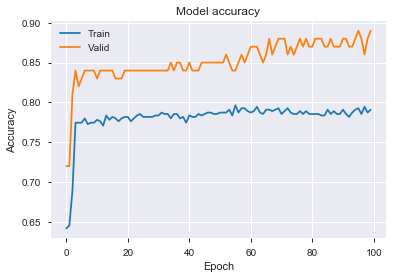

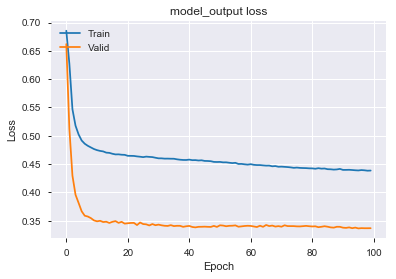

In [21]:
# Plot training & validation accuracy values
plt.plot(grid_result.best_estimator_.model.history.history['acc'])
plt.plot(grid_result.best_estimator_.model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(grid_result.best_estimator_.model.history.history['loss'])
plt.plot(grid_result.best_estimator_.model.history.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Report ROC curves and AUC values

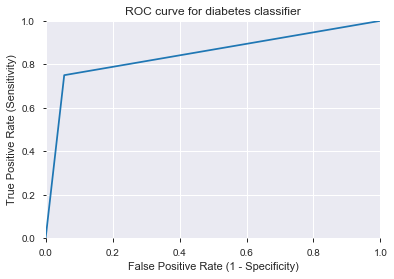

In [22]:
from sklearn.metrics import roc_curve
from sklearn import metrics
y_pred_prob =grid_result.predict(X_valid)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_valid, y_pred_keras)

fpr, tpr, thresholds = metrics.roc_curve(Y_valid, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [24]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
print(auc_keras)

0.8472222222222222


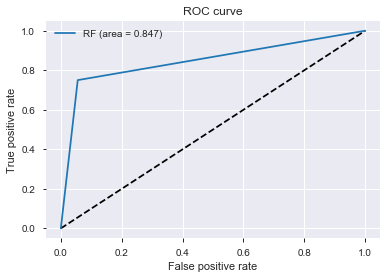

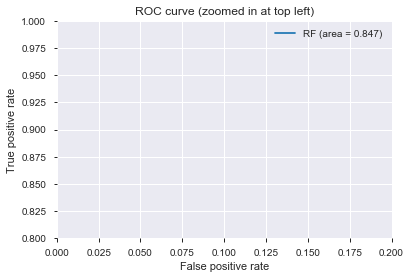

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()



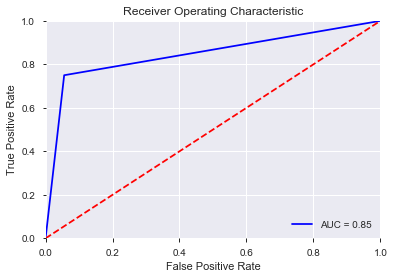

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# VI. Evaluating test set accuracy with the trained model

In [27]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)

(118, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
650,1,91,54,25,100,25.2,0.234,23,0
651,1,117,60,23,106,33.8,0.466,27,0
652,5,123,74,40,77,34.1,0.269,28,0


In [28]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!

Y_t = mydf_test["Outcome"]
X_t = mydf_test.drop(["Outcome"],axis = 1)

print(X_t.shape,Y_t.shape)

(118, 8) (118,)


In [29]:
#Separate continuous and categorical variables/columns for scaling

X_con_t = X_t[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age']]
X_cat_t = X_t.drop(X_con_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(118, 0) (118, 8)


In [30]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age']
print(X_con_sct.shape)
X_con_sct.head(2)


(118, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.833992,-0.903247,-0.745681,0.292298,0.181454,-0.840582,-0.720773,-0.861798
1,-0.833992,-0.099198,-0.439431,0.166972,0.233480,0.251844,-0.036892,-0.518610


In [31]:
print(X_cat_t.shape,X_con_sct.shape)

(118, 0) (118, 8)


In [32]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [33]:
X_cat_t.head()

,index
0,650
1,651
2,652
3,653
4,654


In [34]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

""
0
1


In [35]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(118, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.833992,-0.903247,-0.745681,0.292298,0.181454,-0.840582,-0.720773,-0.861798
1,-0.833992,-0.099198,-0.439431,0.166972,0.233480,0.251844,-0.036892,-0.518610


# Evaluate the model

In [45]:
y_prd_tst = grid_search.predict(X_test_I)
accuracy_score(Y_t,y_prd_tst)

0.7457627118644068